# CODE for Robust Market Making Under Model Uncertainty: The Role of Ambiguity Aversion and Competition


This notebook includes the code for ALL the experiments outlined in the report, including the replication of the experiments in the paper, solving the equations outlined on it, generating all the plots from the original paper, addition of new features and the generation of all the figures that are included in our report. To increase precision of the results, most experiments, are generated using 30,000 different paths, making the computational cost be incredibly high, with some of the experiments being ran for more than a day. In particular, depending on the system that the notebook is ran, the RAM preallocated for some of the computations might not be enough and will make it not possible to run and if wanted to run all the experiments it will take approximately 48h. This comes after making a big effort in the vectorization and speedup of all the functions in the code, which is not reflected in the report but it was one of the most time consuming parts of the coursework. 

In [ ]:
import numpy as np
import pandas as pd
from scipy.linalg import expm
from matplotlib import pyplot as plt
from scipy.integrate import quad
from numpy.random import poisson, normal
from copy import deepcopy
import time

# Replicating Main Results

In [3]:
T = 10
N = 1000
alpha = 0
sigma = 0.01
theta = 0.01

kappa = 15
lambd1, lambd2 = 2, 2

phi_1 = 20
phi = 0

qs = np.arange(-3, 4)

In [1]:
# Linear price impact (terminal liquiadtion)
def l(q):
    return theta*q

In [ ]:
#This corresponds to only drift uncertainty. After we will provide a general implementation that also works for this case.

if phi != 0:
    psi1, psi2 = (1+phi/kappa)**(-(1+kappa/phi))*lambd1, (1+phi/kappa)**(-(1+kappa/phi))*lambd2
else:
    psi1, psi2 = 1/np.exp(1)*lambd1, 1/np.exp(1)*lambd2

# Set phi_1 and construct the matrix A with diagonal and off-diagonal elements
phi_1 = 0
A = np.diag(alpha*kappa*qs - 0.5*kappa*phi_1*(sigma**2)*(qs**2)) + \
    np.diag([psi1] * (len(qs)-1), k=1) + np.diag([psi1] * (len(qs)-1), k=-1)

# Initialize solution matrix w and set final time condition
w = np.zeros((len(qs), N+1))
w[:, -1] = np.exp(-kappa*qs*l(qs))  # Terminal condition for w

# Compute matrix exponential once
eA = expm(A*(T/N))

# Backward recursion to solve the system
for i in reversed(range(N)):
    w[:, i] = eA @ w[:, i+1]

# Compute h based on w
h = np.log(w) / kappa

if phi == 0:
    temp = 1/kappa
else:
    temp = (1/phi) * np.log(1 + phi/kappa)

delta0 = np.maximum(temp + h[1:] - h[:-1], 0)

phi_1 = 20
A = np.diag(alpha*kappa*qs - 0.5*kappa*phi_1*(sigma**2)*(qs**2)) + \
    np.diag([psi1] * (len(qs)-1), k=1) + np.diag([psi1] * (len(qs)-1), k=-1)

w = np.zeros((len(qs), N+1))
w[:, -1] = np.exp(-kappa*qs*l(qs))
eA = expm(A*(T/N))

for i in reversed(range(N)):
    w[:, i] = eA @ w[:, i+1]

h = np.log(w) / kappa

if phi == 0:
    temp = 1/kappa
else:
    temp = (1/phi) * np.log(1 + phi/kappa)

delta_alpha = np.maximum(temp + h[1:] - h[:-1], 0)


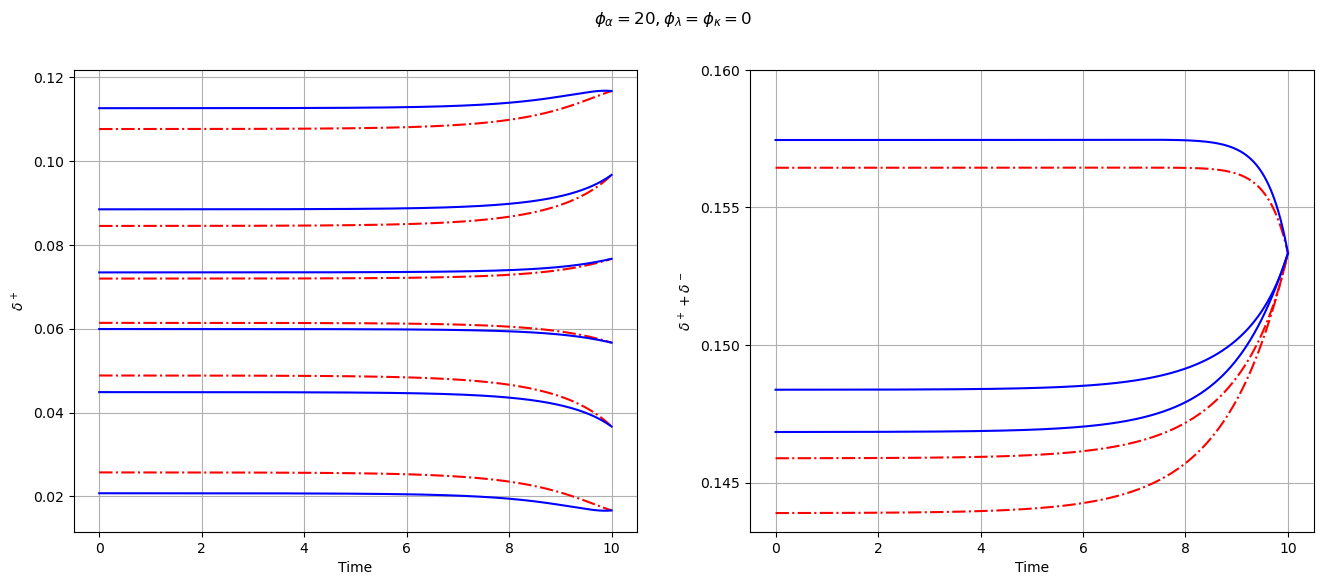

In [6]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
for i in range(len(qs)-1):
    axs[0].plot(np.linspace(0, 10, N+1), delta0[i], c='r', linestyle='-.')
    axs[0].plot(np.linspace(0, 10, N+1), delta_alpha[i], c='b')
for (i, j) in [(0, 4), (1, 3), (2, 2)]:
    axs[1].plot(np.linspace(0, 10, N+1), delta0[i]+delta0[j], c='r', linestyle='-.')
    axs[1].plot(np.linspace(0, 10, N+1), delta_alpha[i]+delta_alpha[j], c='b')
axs[1].set_yticks([0.145, 0.15, 0.155, 0.16]);
axs[0].grid()
axs[1].grid()
axs[0].set_ylabel(r'$\delta^+$')
axs[0].set_xlabel('Time')
axs[1].set_ylabel(r'$\delta^+ + \delta^-$')
axs[1].set_xlabel('Time')
plt.suptitle(rf'$\phi_\alpha = {phi_1}, \phi_\lambda = \phi_\kappa = {phi}$');

Computing the optimal MM spread by solving ODE

In [8]:
def get_delta(phi_alpha, phi_lambd, phi_kappa, T, N):
    h = np.zeros((len(qs), N+1))
    delta1 = np.zeros((len(qs), N+1))
    delta2 = np.zeros((len(qs), N+1))
    delta1[0] = np.inf
    delta2[-1] = np.inf

    # Numerically solving ODE with explicit scheme
    for i in reversed(range(N+1)):
        if i == N:
            h[:, i] = -qs*l(qs)
        else:
            for j, q in enumerate(qs):
                # First sup term in equation A.16 in original paper
                if j == 0:
                    term1 = 0
                else:
                    delta = delta1[j][i+1]
                    if phi_lambd == 0 and phi_kappa == 0:
                        term1 = lambd1*np.exp(-kappa1*delta)*(delta+h[j-1][i+1]-h[j][i+1])
                    elif phi_lambd == 0:
                        term1 = -(lambd1/phi_kappa)*np.log(1-np.exp(-kappa1*delta)+np.exp(-kappa1*delta-phi_kappa*(delta+h[j-1][i+1]-h[j][i+1])))
                    elif phi_kappa == 0:
                        term1 = (lambd1/phi_lambd)*(1-np.exp(-phi_lambd*np.exp(-kappa1*delta)*(delta+h[j-1][i+1]-h[j][i+1])))
                    else:
                        term1 = (lambd1/phi_lambd)*(1-np.exp((phi_lambd/phi_kappa)*
                                                             np.log(1-np.exp(-kappa1*delta)+np.exp(-kappa1*delta-phi_kappa*(delta+h[j-1][i+1]-h[j][i+1])))))
                # Second sup term in equation A.16
                if j == len(qs)-1:
                    term2 = 0
                else:
                    delta = delta2[j][i+1]
                    if phi_lambd == 0 and phi_kappa == 0:
                        term2 = lambd2*np.exp(-kappa2*delta)*(delta+h[j+1][i+1]-h[j][i+1])
                    elif phi_lambd == 0:
                        term2 = -(lambd2/phi_kappa)*np.log(1-np.exp(-kappa2*delta)+np.exp(-kappa2*delta-phi_kappa*(delta+h[j+1][i+1]-h[j][i+1])))
                    elif phi_kappa == 0:
                        term2 = (lambd2/phi_lambd)*(1-np.exp(-phi_lambd*np.exp(-kappa2*delta)*(delta+h[j+1][i+1]-h[j][i+1])))
                    else:
                        term2 = (lambd2/phi_lambd)*(1-np.exp((phi_lambd/phi_kappa)*
                                                             np.log(1-np.exp(-kappa2*delta)+np.exp(-kappa2*delta-phi_kappa*(delta+h[j+1][i+1]-h[j][i+1])))))

                # Updating function h_q(t) iteratively
                h[j][i] = h[j][i+1]+(T/N)*(alpha*q-0.5*phi_alpha*(sigma**2)*(q**2) + term1 + term2)
                    
        if phi_kappa == 0:
            temp1 = 1/kappa1
            temp2 = 1/kappa2
        else:
            temp1 = (1/phi_kappa)*np.log(1+phi_kappa/kappa1)
            temp2 = (1/phi_kappa)*np.log(1+phi_kappa/kappa2)
        delta1[1:, i] = np.maximum(temp1 - h[:-1, i] + h[1:, i], 0)
        delta2[:-1, i] = np.maximum(temp2 - h[1:, i] + h[:-1, i], 0)
    return delta1[1:], delta2[:-1]

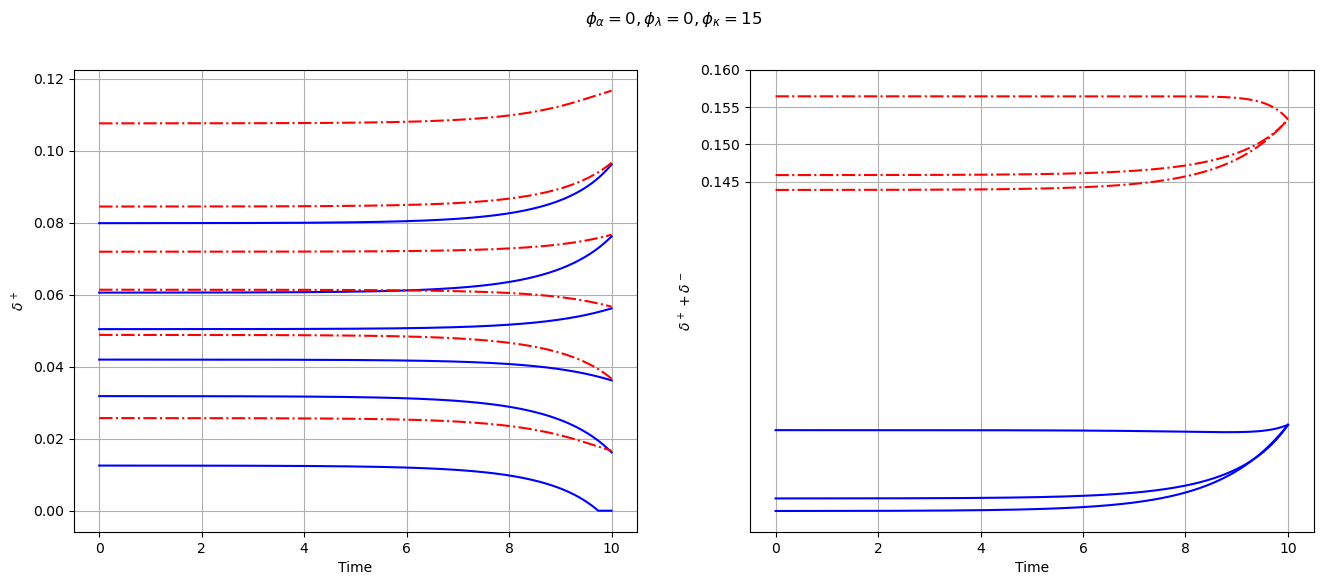

In [9]:
lambd1, lambd2 = 2, 2
kappa1, kappa2 = 15, 15
phi_alpha, phi_lambd, phi_kappa = 0, 0, 15

delta_lambd, _ = get_delta(phi_alpha, phi_lambd, phi_kappa, T, N)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
for i in range(len(qs)-1):
    axs[0].plot(np.linspace(0, 10, N+1), delta0[i], c='r', linestyle='-.')
    axs[0].plot(np.linspace(0, 10, N+1), delta_lambd[i], c='b')
for (i, j) in [(0, 4), (1, 3), (2, 2)]:
    axs[1].plot(np.linspace(0, 10, N+1), delta0[i]+delta0[j], c='r', linestyle='-.')
    axs[1].plot(np.linspace(0, 10, N+1), delta_lambd[i]+delta_lambd[j], c='b')
axs[1].set_yticks([0.145, 0.15, 0.155, 0.16]);
axs[0].grid()
axs[1].grid()
axs[0].set_ylabel(r'$\delta^+$')
axs[0].set_xlabel('Time')
axs[1].set_ylabel(r'$\delta^+ + \delta^-$')
axs[1].set_xlabel('Time')
plt.suptitle(rf'$\phi_\alpha = {phi_alpha}, \phi_\lambda = {phi_lambd}, \phi_\kappa = {phi_kappa}$');

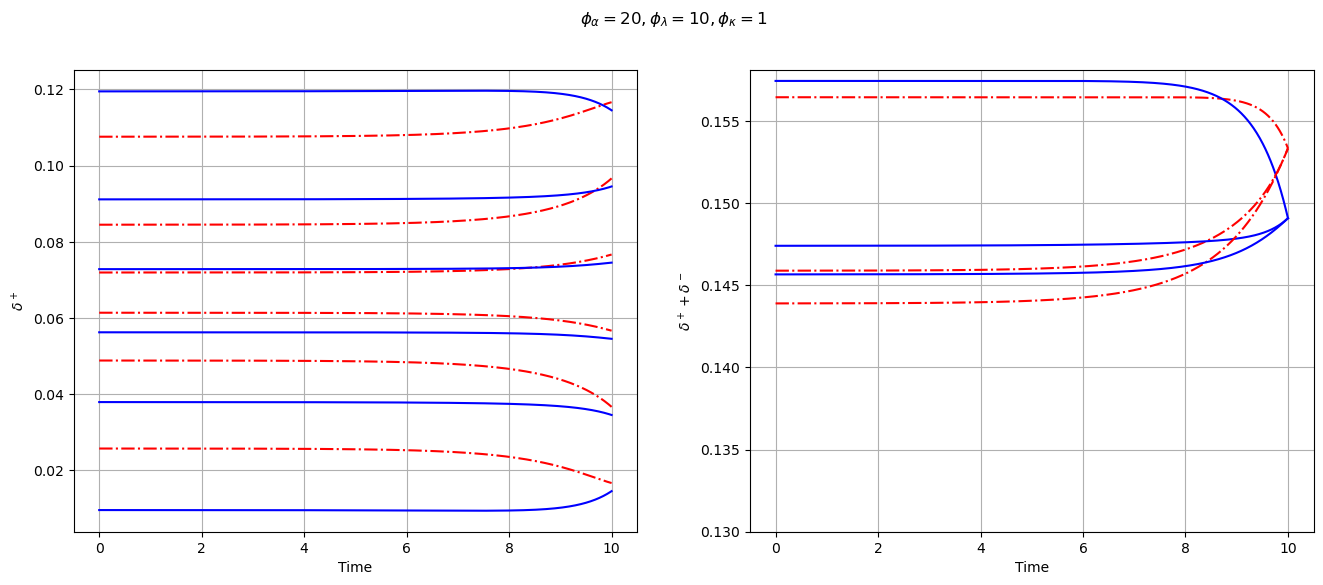

In [10]:
lambd1, lambd2 = 2, 2
kappa1, kappa2 = 15, 15
phi_alpha, phi_lambd, phi_kappa = 20, 10, 1

delta1, _ = get_delta(phi_alpha, phi_lambd, phi_kappa, T, N)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
for i in range(len(qs)-1):
    axs[0].plot(np.linspace(0, 10, N+1), delta0[i], c='r', linestyle='-.')
    axs[0].plot(np.linspace(0, 10, N+1), delta1[i], c='b')
for (i, j) in [(0, 4), (1, 3), (2, 2)]:
    axs[1].plot(np.linspace(0, 10, N+1), delta0[i]+delta0[j], c='r', linestyle='-.')
    axs[1].plot(np.linspace(0, 10, N+1), delta1[i]+delta1[j], c='b')
axs[1].set_yticks(np.arange(0.13, 0.16, 0.005))
axs[0].grid()
axs[1].grid()
axs[0].set_ylabel(r'$\delta^+$')
axs[0].set_xlabel('Time')
axs[1].set_ylabel(r'$\delta^+ + \delta^-$')
axs[1].set_xlabel('Time')
plt.suptitle(rf'$\phi_\alpha = {phi_alpha}, \phi_\lambda = {phi_lambd}, \phi_\kappa = {phi_kappa}$');

## Simulating Market Dynamics

In [ ]:
T = 300
N_total = 6600
N_est = 0
M = 30
S_t = np.zeros((M, N_total+1))
alpha_t = np.zeros((M, N_total+1))
lambd1_t, lambd2_t = np.zeros((M, N_total+1)), np.zeros((M, N_total+1))
kappa1_t, kappa2_t = np.zeros((M, N_total+1)), np.zeros((M, N_total+1))
dM_t1s, dM_t2s = np.zeros((M, N_total+1)), np.zeros((M, N_total+1))
q_bar = 8
qs = np.arange(-q_bar, q_bar+1) #Extend to -8 to 8 for this part.
theta = 0.001

dt = T/N_total

lambd1_t[:, 0], lambd2_t[:, 0] = 2, 2
kappa1_t[:, 0], kappa2_t[:, 0] = 15, 15

sigma = 0.01 #We fix the vol and the drift of the midprice.

#We use the same parameters that were used in the paper.
eps1, eps2 = 0.001, 0.001
b_alpha = 1
theta_lambd = 0.2
b_lambd = 70/9
eta_lambd = 5

nu_lambd = 2
theta_k = 15
b_k = 7/6
eta_k = 5
nu_k = 2


np.random.seed(0)


#Here we simulate the stochastic processes in the paper describing the dynamics of the market, including the stock price. No modification has been done yet.
for i in range(1, N_total+1):
    dM_t1, dM_t2 = poisson(lambd1_t[:, i-1]*T/N_total), poisson(lambd2_t[:, i-1]*T/N_total)
    dM_t1s[:, i], dM_t2s[:, i] = dM_t1, dM_t2
    kappa1_t[:, i] = kappa1_t[:, i-1] + b_k*(theta_k - kappa1_t[:, i-1])*(T/N_total) + eta_k * dM_t1 + nu_k * dM_t2
    kappa2_t[:, i] = kappa2_t[:, i-1] + b_k*(theta_k - kappa2_t[:, i-1])*(T/N_total) + eta_k * dM_t2 + nu_k * dM_t1
    lambd1_t[:, i] = lambd1_t[:, i-1] + b_lambd*(theta_lambd - lambd1_t[:, i-1])*(T/N_total) + eta_lambd * dM_t1 + nu_lambd * dM_t2
    lambd2_t[:, i] = lambd2_t[:, i-1] + b_lambd*(theta_lambd - lambd2_t[:, i-1])*(T/N_total) + eta_lambd * dM_t2 + nu_lambd * dM_t1
    alpha_t[:, i] = alpha_t[:, i-1] - b_alpha*alpha_t[:, i-1]*(T/N_total) + eps1 * dM_t1 - eps2 * dM_t2
    S_t[:, i] = S_t[:, i-1] + alpha_t[:, i-1]*(T/N_total) + sigma*np.sqrt(T/N_total)*normal(0, 1, size=M)
    
dM_t1s, dM_t2s = dM_t1s.astype(int), dM_t2s.astype(int)

### Example price path

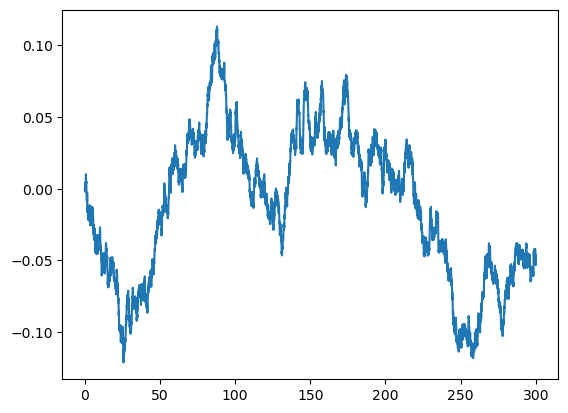

In [19]:
plt.plot(np.linspace(0, T, N_total+1), S_t[6]);

np.float64(27.183048062383893)

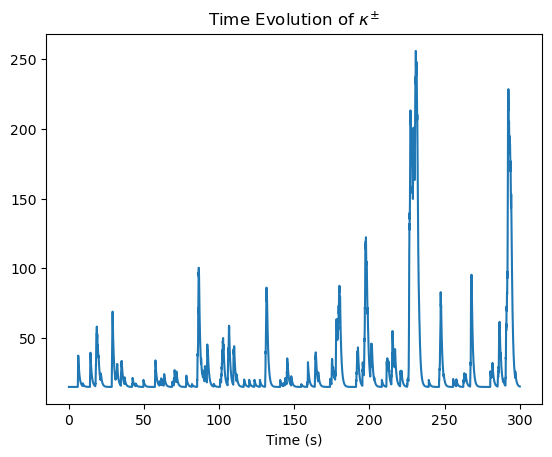

In [20]:
plt.plot(np.linspace(0, T, N_total+1), kappa1_t[6])
plt.title(r'Time Evolution of $\kappa^{\pm}$')
plt.xlabel('Time (s)')

In [ ]:
#Here we obtain all the market orders based on the previously simulated dynamics. 
MO_times_directions = []

for i in range(M):
    MO_time_direction = []
    for j in range(N_est+1, N_total+1):
        if dM_t1s[i][j] >= 1 or dM_t2s[i][j] >= 1:
            total_trades = dM_t1s[i][j]+dM_t2s[i][j]
            directions = np.array([1]*dM_t1s[i][j] + [-1]*dM_t2s[i][j])
            uniform_times = (j-1)*dt + np.random.uniform(size=total_trades)*dt
            directions = directions[uniform_times.argsort()]
            uniform_times.sort()
            MO_time_direction += [[uniform_times[k], directions[k], 0] for k in range(total_trades)]

    MO_times_directions.append(MO_time_direction)

In [ ]:
'''
#All the interpolation functions listed here are used to extend the numerical experiment. 
Market orders arrive at random times which dont have to match the numerical scheme and therefore there is interest in interpolating the stock price, 
the kappas and the deltas (which in the end will be rpecomputed and interpolated in a different way)
'''

def get_interpolated_delta(deltas, t):
    T_est = N_est*dt
    index = int((t-T_est)//numerical_dt)
    if index == len(deltas)-1:
        return deltas[-1]
    else:
        w = (T_est + (index+1)*numerical_dt - t)/numerical_dt
        return w*deltas[index] + (1-w)*deltas[index+1]

def get_interpolated_stock(St, t):
    index = int(t//dt)
    if index >= N_total:
        return St[N_total]
    else:
        w = index + 1 - t/dt
        return w*St[index] + (1-w)*St[index+1]

def get_interpolated_kappa(kappa, t):
    index = int(t//dt)
    if index >= N_total:
        return kappa[N_total]
    else:
        w = index + 1 - t/dt
        return w*kappa[index] + (1-w)*kappa[index+1]

# Faster version of get_delta to make the experiments quicker. Vectorization of one of the loops achieves allmost 2.5 speedup.
def get_delta_parallel(phi_alpha, phi_lambd, phi_kappa, T, N):
    M = len(qs)
    h = np.zeros((M, N+1))
    delta1 = np.zeros((M, N+1))
    delta2 = np.zeros((M, N+1))
    delta1[0, :] = np.inf
    delta2[-1, :] = np.inf

    for i in reversed(range(N+1)):
        if i == N:
            h[:, i] = -qs * l(qs)
        else:
            # Compute term1
            term1 = np.zeros(M)
            if phi_lambd == 0 and phi_kappa == 0:
                term1[1:] = lambd1 * np.exp(-kappa1 * delta1[1:, i+1]) * (
                    delta1[1:, i+1] + h[:-1, i+1] - h[1:, i+1]
                )
            elif phi_lambd == 0:
                term1[1:] = -(lambd1 / phi_kappa) * np.log(
                    1 - np.exp(-kappa1 * delta1[1:, i+1]) +
                    np.exp(-kappa1 * delta1[1:, i+1] - phi_kappa * (
                        delta1[1:, i+1] + h[:-1, i+1] - h[1:, i+1]
                    ))
                )
            elif phi_kappa == 0:
                term1[1:] = (lambd1 / phi_lambd) * (
                    1 - np.exp(-phi_lambd * np.exp(-kappa1 * delta1[1:, i+1]) * (
                        delta1[1:, i+1] + h[:-1, i+1] - h[1:, i+1]
                    ))
                )
            else:
                term1[1:] = (lambd1 / phi_lambd) * (
                    1 - np.exp((phi_lambd / phi_kappa) * np.log(
                        1 - np.exp(-kappa1 * delta1[1:, i+1]) +
                        np.exp(-kappa1 * delta1[1:, i+1] - phi_kappa * (
                            delta1[1:, i+1] + h[:-1, i+1] - h[1:, i+1]
                        ))
                    ))
                )

            # Compute term2
            term2 = np.zeros(M)
            if phi_lambd == 0 and phi_kappa == 0:
                term2[:-1] = lambd2 * np.exp(-kappa2 * delta2[:-1, i+1]) * (
                    delta2[:-1, i+1] + h[1:, i+1] - h[:-1, i+1]
                )
            elif phi_lambd == 0:
                term2[:-1] = -(lambd2 / phi_kappa) * np.log(
                    1 - np.exp(-kappa2 * delta2[:-1, i+1]) +
                    np.exp(-kappa2 * delta2[:-1, i+1] - phi_kappa * (
                        delta2[:-1, i+1] + h[1:, i+1] - h[:-1, i+1]
                    ))
                )
            elif phi_kappa == 0:
                term2[:-1] = (lambd2 / phi_lambd) * (
                    1 - np.exp(-phi_lambd * np.exp(-kappa2 * delta2[:-1, i+1]) * (
                        delta2[:-1, i+1] + h[1:, i+1] - h[:-1, i+1]
                    ))
                )
            else:
                term2[:-1] = (lambd2 / phi_lambd) * (
                    1 - np.exp((phi_lambd / phi_kappa) * np.log(
                        1 - np.exp(-kappa2 * delta2[:-1, i+1]) +
                        np.exp(-kappa2 * delta2[:-1, i+1] - phi_kappa * (
                            delta2[:-1, i+1] + h[1:, i+1] - h[:-1, i+1]
                        ))
                    ))
                )

            # Compute h[:, i]
            h[:, i] = h[:, i+1] + (T / N) * (
                alpha * qs - 0.5 * phi_alpha * (sigma**2) * (qs**2) + term1 + term2
            )

        # Update delta1 and delta2
        if phi_kappa == 0:
            temp1 = 1 / kappa1
            temp2 = 1 / kappa2
        else:
            temp1 = (1 / phi_kappa) * np.log(1 + phi_kappa / kappa1)
            temp2 = (1 / phi_kappa) * np.log(1 + phi_kappa / kappa2)
        delta1[1:, i] = np.maximum(temp1 - h[:-1, i] + h[1:, i], 0)
        delta2[:-1, i] = np.maximum(temp2 - h[1:, i] + h[:-1, i], 0)

    return delta1[1:], delta2[:-1]

Computing terminal wealth per path for a fixed set of aversion parameters

In [ ]:
'''
This function tracks the MM wealth, inventory, as well as quotes and market orders that receives and fills for a given set of uncertainty parameters.
In this case the kappas are not bumped and the MM is not reactive to them.
'''

def get_expected_terminal_wealth(phi_alpha, phi_lambd, phi_kappa):

    start = time.time()
    
    MM_positions = []
    MM_deltas = []
    MM_wealths = []
    terminal_wealths = []
    
    alpha, sigma = 0, 0.01
    delta_pos, delta_neg = get_delta_parallel(phi_alpha, phi_lambd, phi_kappa, T, N_numerical)
    
    for i in range(M):
        
        current_position = 0
        current_wealth = 0
        MM_position = []
        MM_delta = []
        MM_wealth = []
        unif = np.random.uniform(size=(len(MO_times_directions[i])))
        for j, (t, direction, _) in enumerate(MO_times_directions[i]):
            if current_position == -q_bar:
                deltas = (np.inf, get_interpolated_delta(delta_neg[0], t))
            elif current_position == q_bar:
                deltas = (get_interpolated_delta(delta_pos[-1], t), np.inf)
            else:
                deltas = (get_interpolated_delta(delta_pos[current_position+q_bar-1], t), get_interpolated_delta(delta_neg[current_position+q_bar], t))
            stock_price = get_interpolated_stock(S_t[i], t)
            
            if direction == 1:
                if unif[j] < np.exp(-get_interpolated_kappa(kappa1_t[i], t)*deltas[0]):
                    current_position -= 1
                    current_wealth += stock_price + deltas[0]
                    MO_times_directions[i][j][2] = 1
            else:
                if unif[j] < np.exp(-get_interpolated_kappa(kappa2_t[i], t)*deltas[1]):
                    current_position += 1
                    current_wealth -= stock_price - deltas[1]
                    MO_times_directions[i][j][2] = -1
                    
            MM_position.append(current_position)
            MM_delta.append(deltas)
            MM_wealth.append(current_wealth)
        MM_positions.append(MM_position)
        MM_deltas.append(MM_delta)
        MM_wealths.append(MM_wealth)

        if len(MM_position) == 0:
            final_position = 0
        else:
            final_position = MM_position[-1]
            
        terminal_wealth = S_t[i][-1]*final_position+MM_wealths[i][-1] - final_position*l(final_position)
        terminal_wealths.append(terminal_wealth)
    print('Phis: ', phi_alpha, phi_lambd, phi_kappa)
    print('Mean: ', np.round(np.mean(terminal_wealths), 4), 'std: ', np.round(np.std(terminal_wealths), 4))
    print(time.time()-start, 'seconds.')
    print('-'*20)
    return np.mean(terminal_wealths), np.std(terminal_wealths, ddof=1), MM_positions, MM_deltas, MM_wealths

N_numerical = 6000
numerical_dt = (1-N_est/N_total)*T/N_numerical

lambd1, lambd2 = 2, 2
kappa1, kappa2 = 27, 27

phi_alphas = np.linspace(0, 10, 6)
phis = np.linspace(0, 30, 11)
expected_terminal_wealths = np.zeros((len(phi_alphas), len(phis)))
expected_terminal_wealth_stds = np.zeros((len(phi_alphas), len(phis)))

for i, phi_alpha in enumerate(phi_alphas):
    for j, phi in enumerate(phis):
        expected_terminal_wealth, expected_terminal_wealth_std, MM_positions, MM_deltas, MM_wealths = get_expected_terminal_wealth(phi_alpha, phi, phi)
        expected_terminal_wealths[i][j] = expected_terminal_wealth
        expected_terminal_wealth_stds[i][j] = expected_terminal_wealth_std

In [ ]:
print(expected_terminal_wealths)
print(expected_terminal_wealth_stds)
[expected_terminal_wealths[i]/expected_terminal_wealth_stds[i] for i in range(len(expected_terminal_wealths))]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

for i in range(len(expected_terminal_wealths)):
    axs[0].plot(expected_terminal_wealth_stds[i], expected_terminal_wealths[i], label=rf'$\phi_\alpha = {int(phi_alphas[i])}$')
    axs[0].scatter(expected_terminal_wealth_stds[i], expected_terminal_wealths[i], s=8)
    axs[1].plot(phis, expected_terminal_wealths[i]/expected_terminal_wealth_stds[i], label=rf'$\phi_\alpha = {int(phi_alphas[i])}$')
    axs[1].scatter(phis, expected_terminal_wealths[i]/expected_terminal_wealth_stds[i], s=8)
axs[0].set_xlim((axs[0].get_xlim()[0]-0.02, axs[0].get_xlim()[1]+0.02))
axs[0].annotate(rf'$\phi={phis[0]}$', xy=(expected_terminal_wealth_stds[0][0]+0.005, expected_terminal_wealths[0][0]))
#axs[0].annotate(rf'$\phi={phis[0]}$', xy=(expected_terminal_wealth_stds[1][0]+0.005, expected_terminal_wealths[1][0]))
axs[0].annotate(rf'$\phi={phis[-1]}$', xy=(expected_terminal_wealth_stds[0][-1], expected_terminal_wealths[0][-1]-0.02))
#axs[0].annotate(rf'$\phi={phis[-1]}$', xy=(expected_terminal_wealth_stds[1][-1]+0.002, expected_terminal_wealths[1][-1]))

axs[0].set_xlabel('Standard Deviation of Profit')
axs[0].set_ylabel('Expected Profit')
axs[0].legend()
axs[1].set_xlabel(r'$\phi = \phi_\lambda = \phi_\kappa$')
axs[1].set_ylabel(r'Expectation / Std of Profit')
#axs[1].legend();

plt.savefig('Sharpe2.png')
plt.savefig('Sharpe2.eps', format='eps')

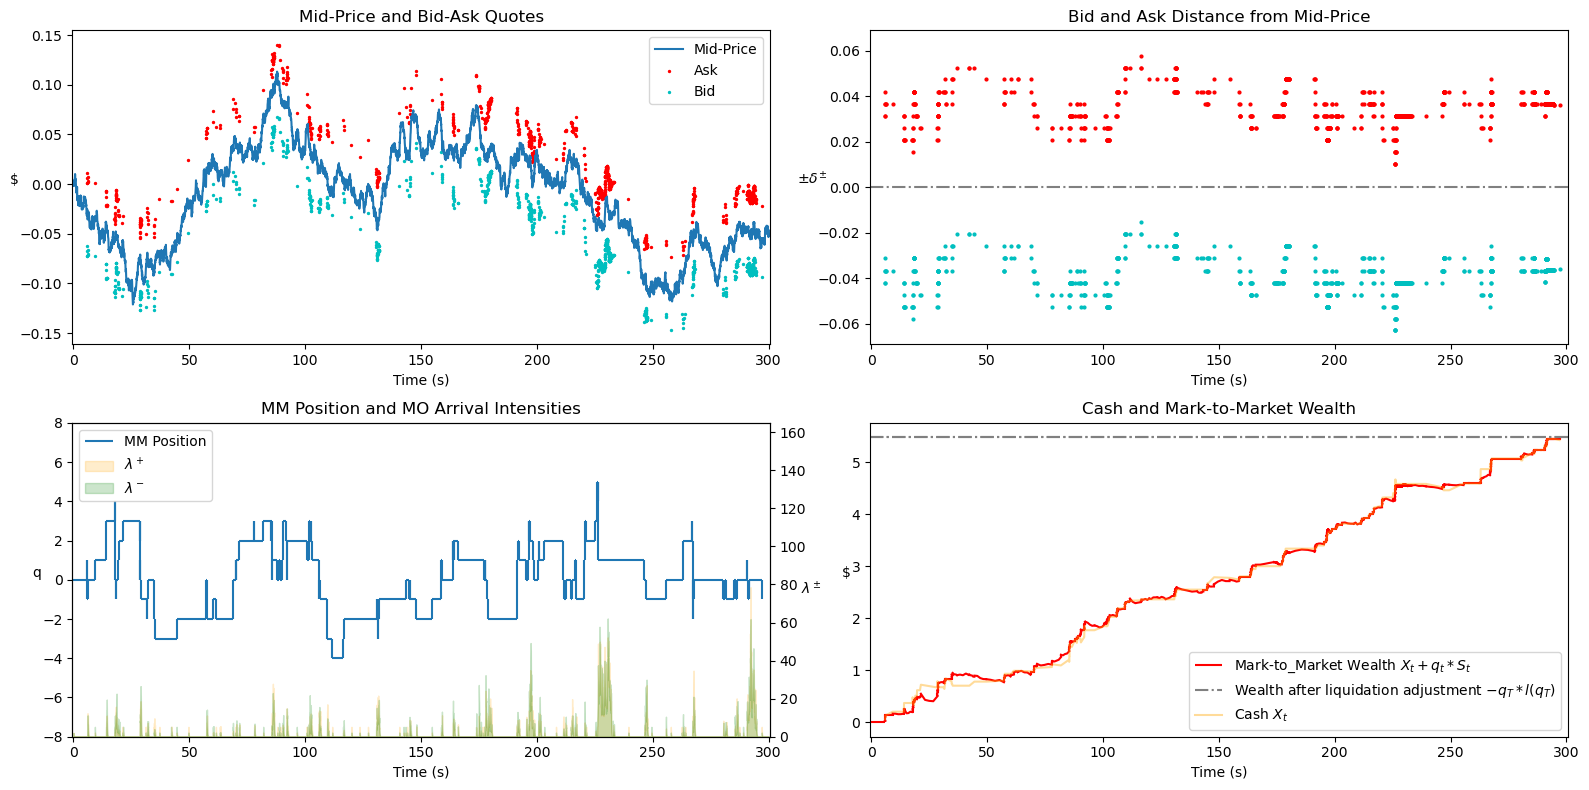

In [25]:
line = 6
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
times = [MO_times_directions[line][i][0] for i in range(len(MO_times_directions[line]))]
axs[0][0].plot(np.linspace(0, T, N_total+1), S_t[line])
axs[0][0].scatter(times, [get_interpolated_stock(S_t[line], times[i]) + elem[0] for i, elem in enumerate(MM_deltas[line])], 
               c='r', s=2)
axs[0][0].scatter(times, [get_interpolated_stock(S_t[line], times[i]) - elem[1] for i, elem in enumerate(MM_deltas[line])],
               c='c', s=2)
axs[0][0].set_title('Mid-Price and Bid-Ask Quotes')
axs[0][0].set_ylabel('$', rotation=0)
axs[0][0].legend(['Mid-Price', 'Ask', 'Bid'])

positions = MM_positions[line]
l1 = axs[1][0].hlines(0, xmin=N_est*T/N_total, xmax=times[0], label='MM Position')
axs[1][0].vlines(times[0], ymin=0, ymax=positions[0])
for i in range(len(times)-1):
    axs[1][0].hlines(positions[i], xmin=times[i], xmax=times[i+1])
    axs[1][0].vlines(times[i+1], ymin=positions[i], ymax=positions[i+1])
axs[1][0].set_ylim((-q_bar, q_bar))
axs[1][0].set_title('MM Position and MO Arrival Intensities')
for i in range(2):
    for j in range(2):
        axs[i][j].set_xlabel('Time (s)')
        axs[i][j].set_xlim((-0.5, T+0.5))
axs[1][0].set_ylabel('q', rotation=0)
area_ax = axs[1][0].twinx()
area_ax.set_ylabel(r'$\lambda^\pm$', rotation=0)
l2 = area_ax.fill_between(np.linspace(N_est*T/N_total, T, N_total-N_est+1), lambd1_t[line][N_est:], color='orange', alpha=0.2, label=r'$\lambda^+$')
l3 = area_ax.fill_between(np.linspace(N_est*T/N_total, T, N_total-N_est+1), lambd2_t[line][N_est:], color='green', alpha=0.2, label=r'$\lambda^-$')
area_ax.set_ylim((0, area_ax.get_ylim()[1]*2))
axs[1][0].legend([l1, l2, l3], [l.get_label() for l in [l1, l2, l3]], loc=2)
        
axs[0][1].scatter(times, [elem[0] for elem in MM_deltas[line]], c='r', s=4)
axs[0][1].scatter(times, [-elem[1] for elem in MM_deltas[line]], c='c', s=4)
axs[0][1].set_ylabel(r'$\pm\delta^{\pm}$', rotation=0)
axs[0][1].set_title('Bid and Ask Distance from Mid-Price')
axs[0][1].axhline(y=0, linestyle='-.', c='grey')
y_max = np.abs(axs[0][1].get_ylim()).max()
axs[0][1].set_ylim((-y_max, y_max))
#axs[0][1].legend(['Ask', 'Bid', 'Mid'])

wealths = MM_wealths[line]
axs[1][1].hlines(y=0, xmin=N_est*T/N_total, xmax=times[0], color='r', label=r'Mark-to_Market Wealth $X_t + q_t*S_t$')
for i in range(len(times)-1):
    ts = np.linspace(times[i], times[i+1], 5)
    axs[1][1].plot(ts, [get_interpolated_stock(S_t[line], t)*positions[i]+wealths[i] for t in ts], c='r')
    stock = get_interpolated_stock(S_t[line], times[i+1])
    axs[1][1].vlines(x=times[i+1], ymin=stock*positions[i]+wealths[i], ymax=stock*positions[i+1]+wealths[i+1], color='r')
axs[1][1].axhline(stock*positions[i+1]+wealths[i+1], c='grey', linestyle='-.')
axs[1][1].axhline(stock*positions[i+1]+wealths[i+1] - positions[-1]*l(positions[-1]), c='grey', linestyle='-.', 
                  label=r'Wealth after liquidation adjustment $-q_T*l(q_T)$')
axs[1][1].plot(times, MM_wealths[line], c='orange', alpha=0.4, label=r'Cash $X_t$')
axs[1][1].set_title('Cash and Mark-to-Market Wealth')
axs[1][1].set_ylabel('$', rotation=0)
axs[1][1].legend()

plt.tight_layout()
plt.savefig('original_results.png')
plt.savefig('original_results.pdf', format='pdf')

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
times = [MO_times_directions[line][i][0] for i in range(len(MO_times_directions[line]))]
axs.plot(np.linspace(0, T, N_total+1), S_t[line])
axs.scatter(times, [get_interpolated_stock(S_t[line], times[i]) + elem[0] for i, elem in enumerate(MM_deltas[line])], 
               c='r', s=2)
axs.scatter(times, [get_interpolated_stock(S_t[line], times[i]) - elem[1] for i, elem in enumerate(MM_deltas[line])],
               c='c', s=2)
axs.set_title('Mid-Price and Bid-Ask Quotes')
axs.legend(['Mid-Price', 'Ask', 'Bid'])
axs.set_ylabel('$', rotation=0)
axs.set_xlabel('Time (s)')
axs.set_xlim((-0.5, T+0.5))
plt.tight_layout()
plt.savefig('original_figure1.png')
plt.savefig('original_figure1.pdf', format='pdf')
plt.show()


fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
positions = MM_positions[line]
l1 = axs.hlines(0, xmin=N_est*T/N_total, xmax=times[0], label='MM Position')
axs.vlines(times[0], ymin=0, ymax=positions[0])
for i in range(len(times)-1):
    axs.hlines(positions[i], xmin=times[i], xmax=times[i+1])
    axs.vlines(times[i+1], ymin=positions[i], ymax=positions[i+1])
axs.set_ylim((-q_bar, q_bar))
axs.set_xlabel('Time (s)')
axs.set_xlim((-0.5, T+0.5))
axs.set_title('MM Position and MO Arrival Intensities')
axs.set_ylabel('q', rotation=0)
area_ax = axs.twinx()
area_ax.set_ylabel(r'$\lambda^\pm$', rotation=0)
l2 = area_ax.fill_between(np.linspace(N_est*T/N_total, T, N_total-N_est+1), lambd1_t[line][N_est:], color='orange', alpha=0.2, label=r'$\lambda^+$')
l3 = area_ax.fill_between(np.linspace(N_est*T/N_total, T, N_total-N_est+1), lambd2_t[line][N_est:], color='green', alpha=0.2, label=r'$\lambda^-$')
area_ax.set_ylim((0, area_ax.get_ylim()[1]*2))
axs.legend([l1, l2, l3], [l.get_label() for l in [l1, l2, l3]], loc=2)
plt.tight_layout()
plt.savefig('original_figure2.png')
plt.savefig('original_figure2.pdf', format='pdf')
plt.show()


fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
axs.scatter(times, [elem[0] for elem in MM_deltas[line]], c='r', s=4)
axs.scatter(times, [-elem[1] for elem in MM_deltas[line]], c='c', s=4)
axs.set_ylabel(r'$\pm\delta^{\pm}$', rotation=0)
axs.set_title('Bid and Ask Distance from Mid-Price')
axs.axhline(y=0, linestyle='-.', c='grey')
y_max = np.abs(axs.get_ylim()).max()
axs.set_ylim((-y_max, y_max))
axs.set_xlabel('Time (s)')
axs.set_xlim((-0.5, T+0.5))
axs.legend(['Ask', 'Bid', 'Mid'])
plt.tight_layout()
plt.savefig('original_figure3.png')
plt.savefig('original_figure3.pdf', format='pdf')
plt.show()


fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
wealths = MM_wealths[line]
axs.hlines(y=0, xmin=N_est*T/N_total, xmax=times[0], color='r', label=r'Mark-to_Market Wealth $X_t + q_t*S_t$')
for i in range(len(times)-1):
    ts = np.linspace(times[i], times[i+1], 5)
    axs.plot(ts, [get_interpolated_stock(S_t[line], t)*positions[i]+wealths[i] for t in ts], c='r')
    stock = get_interpolated_stock(S_t[line], times[i+1])
    axs.vlines(x=times[i+1], ymin=stock*positions[i]+wealths[i], ymax=stock*positions[i+1]+wealths[i+1], color='r')
axs.axhline(stock*positions[i+1]+wealths[i+1], c='grey', linestyle='-.')
axs.axhline(stock*positions[i+1]+wealths[i+1] - positions[-1]*l(positions[-1]), c='grey', linestyle='-.', 
                  label=r'Wealth after liquidation adjustment $-q_T*l(q_T)$')
axs.plot(times, MM_wealths[line], c='orange', alpha=0.4, label=r'Cash $X_t$')
axs.set_title('Cash and Mark-to-Market Wealth')
axs.set_xlabel('Time (s)')
axs.set_xlim((-0.5, T+0.5))
axs.set_ylabel('$', rotation=0)
axs.legend()
plt.tight_layout()
plt.savefig('original_figure4.png')
plt.savefig('original_figure4.pdf', format='pdf')
plt.show()

# -----------------------------------------------------------------------------------

# New model with Kappa bump

In this section we change the dynamics of the kappas, introducing reactions for the amount of fills that the MM is getting, which makes the spreades tighter. The computational 
bottleneck is the recalibration of the quotes of the MM, because it requries solving the numerical problem backwards and takes long. In the beggining we do not need to update
the MMs deltas, keeping its kappas constant (without reacting to the new market dynamics) which as we will explain in the report will make him not trade with anyone and therefore 
be exposed to market risk, which in certain situations will make him loose money.

In [ ]:
"""
Functions to be used to interpolate the deltas. Used after when the MM updates its kappas and therefore deltas (changes his quotes)
"""
def get_interpolated_delta_tick(deltas, t):
    T_est = N_est*dt
    index = int((t-T_est)//numerical_dt)
    if index == len(deltas)-1:
        return deltas[-1]
    else:
        w = (T_est + (index+1)*numerical_dt - t)/numerical_dt
        return np.ceil(((w*deltas[index] + (1-w)*deltas[index+1])+zero_distance_epsilon)/tick_size)*tick_size

In [ ]:
"""
We only precompute certain deltas (every delta takes around 10-15 seconds) so this function returns the associated precomputed delta or
 in certain extreme cases in computes it (we will not rpecompute deltas for cases that happen with really low frequency).
"""
def estimate_delta():
    if kappa1 > 30:
        index1 = round((kappa1-30)//10)+15
    else:
        if kappa1 < 1:
            return get_delta_parallel(phi_alpha, phi_lambd, phi_kappa, T, N_numerical)
        else:
            index1 = round(kappa1)-15
    if kappa2 > 30:
        index2 = round((kappa2-30)//10)+15
    else:
        if kappa2 < 1:
            return get_delta_parallel(phi_alpha, phi_lambd, phi_kappa, T, N_numerical)
        else:
            index2 = round(kappa2)-15

    if index1 <= index2:
        return precomputed_deltas[(index1, index2)]
    else:
        temp = precomputed_deltas[(index2, index1)]
        return [temp[1][::-1, :], temp[0][::-1, :]]

## Not updating Kappa

In [ ]:
'''
Same behaviour as in get_expected_terminal_wealth() but in this case we keep track of the fills that the MM is getting in every period of time (variable current_period_trades) 
and we bump the processes kappa1_t and kappa2_t. This makes the dynamics different becasue before we could compute first the dynamics and then run the MM strategy but in this case 
it cannot be done that way. N_est accounts for time to estimate the midprice drift and volatility when working with real price dynamics, in this case for representational and 
computational purposes it has been kept to 0 but with real world data dynamics these are parameters that would need to be continously calibrated.
'''

T = 300
N_total = 6000
N_est = 0
M = 500
S_t = np.zeros((M, N_total+1))
alpha_t = np.zeros((M, N_total+1))
lambd1_t, lambd2_t = np.zeros((M, N_total+1)), np.zeros((M, N_total+1))
kappa1_t, kappa2_t = np.zeros((M, N_total+1)), np.zeros((M, N_total+1))
dM_t1s, dM_t2s = np.zeros((M, N_total+1)), np.zeros((M, N_total+1))
q_bar = 8
qs = np.arange(-q_bar, q_bar+1)
theta = 0.001

dt = T/N_total

lambd1_t[:, 0], lambd2_t[:, 0] = 2, 2
kappa1_t[:, 0], kappa2_t[:, 0] = 15, 15

sigma = 0.01
eps1, eps2 = 0.001, 0.001
b_alpha = 1
theta_lambd = 0.2
b_lambd = 70/9
eta_lambd = 5

nu_lambd = 2
theta_k = 15
b_k = 7/6
eta_k = 5
nu_k = 2


np.random.seed(0)

N_numerical = 6000
numerical_dt = (1-N_est/N_total)*T/N_numerical
lambd1, lambd2 = 2, 2
kappa1, kappa2 = 27, 27
phi_alpha = 10
phi_lambd, phi_kappa = 6, 6

alpha, sigma = 0, 0.01
delta_pos, delta_neg = get_delta_parallel(phi_alpha, phi_lambd, phi_kappa, T, N_numerical)

MO_times_directions = []
MM_positions, MM_deltas, MM_wealths = [], [], []

time1, time2, time3 = 0, 0, 0

for j in range(M):
    MO_time_direction = []
    MM_position, MM_delta, MM_wealth = [], [], []
    current_position = 0
    current_wealth = 0
    total_MM_orders = 0
    current_period_trades = 0
    for i in range(1, N_est+1):
        dM_t1, dM_t2 = poisson(lambd1_t[j, i-1]*T/N_total), poisson(lambd2_t[j, i-1]*T/N_total)
        dM_t1s[j, i], dM_t2s[j, i] = dM_t1, dM_t2
        kappa1_t[j, i] = kappa1_t[j, i-1] + b_k*(theta_k + total_MM_orders - kappa1_t[j, i-1])*(T/N_total) + eta_k * dM_t1 + nu_k * dM_t2
        kappa2_t[j, i] = kappa2_t[j, i-1] + b_k*(theta_k + total_MM_orders - kappa2_t[j, i-1])*(T/N_total) + eta_k * dM_t2 + nu_k * dM_t1
        lambd1_t[j, i] = lambd1_t[j, i-1] + b_lambd*(theta_lambd - lambd1_t[j, i-1])*(T/N_total) + eta_lambd * dM_t1 + nu_lambd * dM_t2
        lambd2_t[j, i] = lambd2_t[j, i-1] + b_lambd*(theta_lambd - lambd2_t[j, i-1])*(T/N_total) + eta_lambd * dM_t2 + nu_lambd * dM_t1
        alpha_t[j, i] = alpha_t[j, i-1] - b_alpha*alpha_t[j, i-1]*(T/N_total) + eps1 * dM_t1 - eps2 * dM_t2
        S_t[j, i] = S_t[j, i-1] + alpha_t[j, i-1]*(T/N_total) + sigma*np.sqrt(T/N_total)*normal(0, 1)
    for i in range(N_est, N_total+1):
        start = time.time()
        dM_t1, dM_t2 = poisson(lambd1_t[j, i-1]*T/N_total), poisson(lambd2_t[j, i-1]*T/N_total)
        dM_t1s[j, i], dM_t2s[j, i] = dM_t1, dM_t2
        kappa1_t[j, i] = kappa1_t[j, i-1] + b_k*(theta_k + total_MM_orders - kappa1_t[j, i-1])*(T/N_total) + eta_k * dM_t1 + nu_k * dM_t2 + 25 * current_period_trades
        kappa2_t[j, i] = kappa2_t[j, i-1] + b_k*(theta_k + total_MM_orders - kappa2_t[j, i-1])*(T/N_total) + eta_k * dM_t2 + nu_k * dM_t1 + 25 * current_period_trades
        lambd1_t[j, i] = lambd1_t[j, i-1] + b_lambd*(theta_lambd - lambd1_t[j, i-1])*(T/N_total) + eta_lambd * dM_t1 + nu_lambd * dM_t2
        lambd2_t[j, i] = lambd2_t[j, i-1] + b_lambd*(theta_lambd - lambd2_t[j, i-1])*(T/N_total) + eta_lambd * dM_t2 + nu_lambd * dM_t1
        alpha_t[j, i] = alpha_t[j, i-1] - b_alpha*alpha_t[j, i-1]*(T/N_total) + eps1 * dM_t1 - eps2 * dM_t2
        S_t[j, i] = S_t[j, i-1] + alpha_t[j, i-1]*(T/N_total) + sigma*np.sqrt(T/N_total)*normal(0, 1)
        time1 += time.time()-start
        current_period_trades = 0
        if dM_t1 >= 1 or dM_t2 >= 1:
            start = time.time()
            total_trades = dM_t1+dM_t2
            directions = np.array([1]*dM_t1 + [-1]*dM_t2)
            uniform_times = (i-1)*dt + np.random.uniform(size=total_trades)*dt
            directions = directions[uniform_times.argsort()]
            uniform_times.sort()
            time2 += time.time()-start
            start = time.time()
            for k in range(total_trades):
                if current_position == -q_bar:
                    deltas = (np.inf, get_interpolated_delta(delta_neg[0], uniform_times[k]))
                elif current_position == q_bar:
                    deltas = (get_interpolated_delta(delta_pos[-1], uniform_times[k]), np.inf)
                else:
                    deltas = (get_interpolated_delta(delta_pos[current_position+q_bar-1], uniform_times[k]), 
                              get_interpolated_delta(delta_neg[current_position+q_bar], uniform_times[k]))
                stock_price = get_interpolated_stock(S_t[j], uniform_times[k])
                
                if directions[k] == 1:
                    temp = np.random.uniform()
                    
                    if temp < np.exp(-get_interpolated_kappa(kappa1_t[j], uniform_times[k])*deltas[0]):
                        current_position -= 1
                        current_period_trades += 1
                        current_wealth += stock_price + deltas[0]
                        MO_time_direction.append([uniform_times[k], 1, 1])
                    else:
                        MO_time_direction.append([uniform_times[k], 1, 0])
                        
                else:
                    temp = np.random.uniform()
                    
                    if temp < np.exp(-get_interpolated_kappa(kappa2_t[j], uniform_times[k])*deltas[1]):
                        current_position += 1
                        current_period_trades += 1
                        current_wealth -= stock_price - deltas[1]
                        MO_time_direction.append([uniform_times[k], -1, -1])
                    else:
                        MO_time_direction.append([uniform_times[k], -1, 0])
                MM_position.append(current_position)
                MM_delta.append(deltas)
                MM_wealth.append(current_wealth)
            time3 += time.time()-start
        total_MM_orders = 0.9995*total_MM_orders + 15*current_period_trades
    MM_positions.append(MM_position)
    MM_deltas.append(MM_delta)
    MM_wealths.append(MM_wealth)
    MO_times_directions.append(MO_time_direction)
print(time1, time2, time3)

In [ ]:
line = 376

plt.plot(np.linspace(0, T, N_total+1), kappa1_t[line], c='r')

plt.title(r'Time Evolution of $\kappa^{\pm}$')

plt.tight_layout()
plt.savefig('Kappa.png')
plt.savefig('Kappa.pdf', format='pdf')

In [ ]:
terminal_wealth = [MM_wealths[i][-1] + MM_positions[i][-1]*(S_t[i][-1]-l(MM_positions[i][-1])) for i in range(M)]
print(f'Mean: {np.mean(terminal_wealth)}, Std: {np.std(terminal_wealth, ddof=1)}')
print(f'Sharpe: {np.mean(terminal_wealth)/np.std(terminal_wealth, ddof=1)}')

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
times = [MO_times_directions[line][i][0] for i in range(len(MO_times_directions[line]))]
axs[0][0].plot(np.linspace(0, T, N_total+1), S_t[line])
axs[0][0].scatter(times, [get_interpolated_stock(S_t[line], times[i]) + elem[0] for i, elem in enumerate(MM_deltas[line])], 
               c='r', s=2)
axs[0][0].scatter(times, [get_interpolated_stock(S_t[line], times[i]) - elem[1] for i, elem in enumerate(MM_deltas[line])],
               c='c', s=2)
axs[0][0].set_title('Mid-Price and Bid-Ask Quotes')
axs[0][0].legend(['Mid-Price', 'Ask', 'Bid'])
axs[0][0].axvline(x=45, c='green', linestyle='-.')
axs[0][0].axvline(x=85, c='green', linestyle='-.')

positions = MM_positions[line]
l1 = axs[1][0].hlines(0, xmin=N_est*T/N_total, xmax=times[0], label='MM Position')
axs[1][0].vlines(times[0], ymin=0, ymax=positions[0])
for i in range(len(times)-1):
    axs[1][0].hlines(positions[i], xmin=times[i], xmax=times[i+1])
    axs[1][0].vlines(times[i+1], ymin=positions[i], ymax=positions[i+1])
axs[1][0].set_ylim((-q_bar, q_bar))
axs[1][0].set_title('MM Position and MO Arrival Intensities')
axs[1][0].axvline(x=45, c='green', linestyle='-.')
axs[1][0].axvline(x=85, c='green', linestyle='-.')
for i in range(2):
    for j in range(2):
        axs[i][j].set_xlabel('Time')
        axs[i][j].set_xlim((-0.5, T+0.5))
axs[1][0].set_ylabel('q', rotation=0)
area_ax = axs[1][0].twinx()
area_ax.set_ylabel(r'$\lambda^\pm$', rotation=0)
l2 = area_ax.fill_between(np.linspace(N_est*T/N_total, T, N_total-N_est+1), lambd1_t[line][N_est:], color='orange', alpha=0.2, label=r'$\lambda^+$')
l3 = area_ax.fill_between(np.linspace(N_est*T/N_total, T, N_total-N_est+1), lambd2_t[line][N_est:], color='green', alpha=0.2, label=r'$\lambda^-$')
area_ax.set_ylim((0, area_ax.get_ylim()[1]*2))
axs[1][0].legend([l1, l2, l3], [l.get_label() for l in [l1, l2, l3]], loc=2)
        
axs[0][1].scatter(times, [elem[0] for elem in MM_deltas[line]], c='r', s=2)
axs[0][1].scatter(times, [-elem[1] for elem in MM_deltas[line]], c='c', s=2)
axs[0][1].set_ylabel(r'$\pm\delta^{\pm}$', rotation=0)
axs[0][1].set_title('Bid-Ask Distance from Mid-Price and Average Max/Min Distance of Market Orders')
y_max = np.abs(axs[0][1].get_ylim()).max()
axs[0][1].plot(np.linspace(0, T, N_total+1), 1/kappa1_t[line])
axs[0][1].plot(np.linspace(0, T, N_total+1), -1/kappa2_t[line])
axs[0][1].axhline(y=0, linestyle='-.', c='grey')

#y_max = np.abs(axs[0][1].get_ylim()).max()
axs[0][1].set_ylim((-y_max, y_max))
axs[0][1].legend(['Ask', 'Bid', r'1/$\kappa^+_t$', r'1/$\kappa^-_t$'], loc='lower right')

wealths = MM_wealths[line]
axs[1][1].hlines(y=0, xmin=N_est*T/N_total, xmax=times[0], color='r', label=r'Mark-to_Market Wealth $X_t + q_t*S_t$')
for i in range(len(times)-1):
    ts = np.linspace(times[i], times[i+1], 5)
    axs[1][1].plot(ts, [get_interpolated_stock(S_t[line], t)*positions[i]+wealths[i] for t in ts], c='r')
    stock = get_interpolated_stock(S_t[line], times[i+1])
    axs[1][1].vlines(x=times[i+1], ymin=stock*positions[i]+wealths[i], ymax=stock*positions[i+1]+wealths[i+1], color='r')
axs[1][1].axhline(stock*positions[i+1]+wealths[i+1], c='grey', linestyle='-.')
axs[1][1].axhline(stock*positions[i+1]+wealths[i+1] - positions[-1]*l(positions[-1]), c='grey', linestyle='-.', 
                  label=r'Wealth after liquidation adjustment $-q_T*l(q_T)$')
axs[1][1].plot(times, MM_wealths[line], c='orange', alpha=0.4, label=r'Cash $X_t$')
axs[1][1].set_title('Cash and Mark-to-Market Wealth')
axs[1][1].axvline(x=45, c='green', linestyle='-.')
axs[1][1].axvline(x=85, c='green', linestyle='-.')
axs[1][1].legend()

plt.tight_layout()
plt.savefig('KappaNoUpdate.png')
plt.savefig('KappaNoUpdate.pdf', format='pdf')

## Updating Kappa

In [ ]:
'''
As it was commented prevously, we precompute just a certain amount of deltas, 53 in particular, we try to be more precise for lower kappas because the difference is proportionaly bigger for the deltas.
Given that the tick size is fixed to 0.0025 the max kappa is 400 that is why that is the max kappa that we precompute deltas for. This code precomputes for a given set of uncertainty parameters the deltas
at each different position of inventory hold (-8 to 8).
'''

# 53 values
kappa_range = np.concat((np.arange(15, 31, 1), np.arange(40, 405, 10)))
precomputed_deltas = {}
for i in range(len(kappa_range)):
    for j in range(i, len(kappa_range)):
        delta1, delta2 = kappa_range[i], kappa_range[j]
        delta_pos, delta_neg = get_delta_parallel(phi_alpha, phi_lambd, phi_kappa, T, N_numerical)
        precomputed_deltas[(i, j)] = np.array((delta_pos, delta_neg))

In [ ]:
'''
Same behaviour as before but in this case every 5 seconds we check for the amount of market orders received (below and above the midprice) and in case there is enough to 
update our kappas (enough has been set to 10 operations) we update the kappa from that side to the mean of the market kappa of that operation and we change the MMs deltas
(using the interpolating function from before).
'''

T = 300
N_total = 6000
N_est = 0
M = 1

update_rate = 100
tick_size = 0.0025
zero_distance_epsilon = 10**-7

S_t = np.zeros((M, N_total+1))
alpha_t = np.zeros((M, N_total+1))
lambd1_t, lambd2_t = np.zeros((M, N_total+1)), np.zeros((M, N_total+1))
kappa1_t, kappa2_t = np.zeros((M, N_total+1)), np.zeros((M, N_total+1))
dM_t1s, dM_t2s = np.zeros((M, N_total+1)), np.zeros((M, N_total+1))
q_bar = 8
qs = np.arange(-q_bar, q_bar+1)
theta = 0.001

dt = T/N_total

lambd1_t[:, 0], lambd2_t[:, 0] = 2, 2
kappa1_t[:, 0], kappa2_t[:, 0] = 15, 15

sigma = 0.01
eps1, eps2 = 0.001, 0.001
b_alpha = 1
theta_lambd = 0.2
b_lambd = 70/9
eta_lambd = 5

nu_lambd = 2
theta_k = 15
b_k = 7/6
eta_k = 5
nu_k = 2

np.random.seed(0)

N_numerical = 6000
numerical_dt = (1-N_est/N_total)*T/N_numerical
lambd1, lambd2 = 2, 2
kappa1, kappa2 = 27, 27

phi_alpha = 10
phi_lambd, phi_kappa = 6, 6
estimated_kappas1, estimated_kappas2 = [], []
alpha, sigma = 0, 0.01

MO_times_directions = []
MM_positions, MM_deltas, MM_wealths = [], [], []

time0, time01, time1, time2, time3 = 0, 0, 0, 0, 0

for j in range(M):
    kappa1, kappa2 = 27, 27
    estimated_kappa1, estimated_kappa2 = [kappa1], [kappa2]
    distances_over, distances_under = [], []
    MO_time_direction = []
    MM_position, MM_delta, MM_wealth = [], [], []
    current_position = 0
    current_wealth = 0
    total_MM_orders_1, total_MM_orders_2 = 0, 0
    current_period_trades1, current_period_trades2 = 0, 0

    delta_pos, delta_neg = estimate_delta()

    z = normal(0, 1, N_total)
    
    for i in range(1, N_total+1):
        if i%update_rate == 0:
            start = time.time()
            if len(distances_over) > 10:
                kappa1 = 1/np.mean(distances_over)
                estimated_kappa1.append(kappa1)
            else:
                estimated_kappa1.append(estimated_kappa1[-1])
            if len(distances_under) > 10:
                kappa2 = 1/np.mean(distances_under)
                estimated_kappa2.append(kappa2)
            else:
                estimated_kappa2.append(estimated_kappa2[-1])
            time0 += time.time()-start
            start = time.time()
            if len(distances_under) > 10 or len(distances_over) > 10:
                delta_pos, delta_neg = estimate_delta()
            if len(distances_over) > 10:
                distances_over = []
            if len(distances_under) > 10:
                distances_under = []
            time01 += time.time()-start
            
        start = time.time()
        dM_t1, dM_t2 = poisson(lambd1_t[j, i-1]*dt), poisson(lambd2_t[j, i-1]*dt)
        dM_t1s[j, i], dM_t2s[j, i] = dM_t1, dM_t2
        kappa1_t[j, i] = kappa1_t[j, i-1] + b_k*(theta_k + total_MM_orders_1 - kappa1_t[j, i-1])*dt + eta_k * dM_t1 + nu_k * dM_t2
        kappa2_t[j, i] = kappa2_t[j, i-1] + b_k*(theta_k + total_MM_orders_2 - kappa2_t[j, i-1])*dt + eta_k * dM_t2 + nu_k * dM_t1
        lambd1_t[j, i] = lambd1_t[j, i-1] + b_lambd*(theta_lambd - lambd1_t[j, i-1])*dt + eta_lambd * dM_t1 + nu_lambd * dM_t2
        lambd2_t[j, i] = lambd2_t[j, i-1] + b_lambd*(theta_lambd - lambd2_t[j, i-1])*dt + eta_lambd * dM_t2 + nu_lambd * dM_t1
        alpha_t[j, i] = alpha_t[j, i-1] - b_alpha*alpha_t[j, i-1]*dt + eps1 * dM_t1 - eps2 * dM_t2
        S_t[j, i] = S_t[j, i-1] + alpha_t[j, i-1]*dt + sigma*np.sqrt(dt)*z[i-1]
        time1 += time.time()-start
        current_period_trades1, current_period_trades2 = 0, 0
        if dM_t1 >= 1 or dM_t2 >= 1:
            start = time.time()
            total_trades = dM_t1+dM_t2
            directions = np.array([1]*dM_t1 + [-1]*dM_t2)
            uniform_times = (i-1)*dt + np.random.uniform(size=total_trades)*dt
            directions = directions[uniform_times.argsort()]
            uniform_times.sort()
            time2 += time.time()-start
            start = time.time()
            for k in range(total_trades):
                if current_position == -q_bar:
                    d = get_interpolated_delta_tick(delta_neg[0], uniform_times[k])
                    deltas = (np.inf, d)
                elif current_position == q_bar:
                    d = get_interpolated_delta_tick(delta_pos[-1], uniform_times[k])
                    deltas = (d, np.inf)
                else:
                    d1 = get_interpolated_delta_tick(delta_pos[current_position+q_bar-1], uniform_times[k])
                    d2 = get_interpolated_delta_tick(delta_neg[current_position+q_bar], uniform_times[k])
                    deltas = (d1, d2)
                
                stock_price = get_interpolated_stock(S_t[j], uniform_times[k])
                u = np.random.uniform()
                if directions[k] == 1:
                    kappa_aux = get_interpolated_kappa(kappa1_t[j], uniform_times[k])
                    distance_over = -(1/kappa_aux)*np.log(u)
                    
                    if distance_over>deltas[0]:
                        current_position -= 1
                        current_period_trades1 += 1
                        current_wealth += stock_price + deltas[0]
                        MO_time_direction.append([uniform_times[k], 1, 1])
                    else:
                        MO_time_direction.append([uniform_times[k], 1, 0])

                    distance_over = np.ceil((distance_over+zero_distance_epsilon) / tick_size) * tick_size
                    distances_over.append(distance_over)
                        
                else:
                    kappa_aux = get_interpolated_kappa(kappa2_t[j], uniform_times[k])
                    distance_under =-(1/kappa_aux)*np.log(u)
                    
                    if distance_under>deltas[1]:
                        current_position += 1
                        current_period_trades2 += 1
                        current_wealth -= stock_price - deltas[1]
                        MO_time_direction.append([uniform_times[k], -1, -1])
                    else:
                        MO_time_direction.append([uniform_times[k], -1, 0])
                    distance_under = np.ceil((distance_under+zero_distance_epsilon) / tick_size) * tick_size
                    distances_under.append(distance_under)
                MM_position.append(current_position)
                MM_delta.append(deltas)
                MM_wealth.append(current_wealth)
            time3 += time.time()-start
        total_MM_orders_1 = 30*current_period_trades1 + 0.99*total_MM_orders_1
        total_MM_orders_2 = 30*current_period_trades2+ 0.99*total_MM_orders_2
    MM_positions.append(MM_position)
    estimated_kappas2.append(estimated_kappa2)
    estimated_kappas1.append(estimated_kappa1)
    MM_deltas.append(MM_delta)
    MM_wealths.append(MM_wealth)
    MO_times_directions.append(MO_time_direction)

print(time0, time01, time1, time2, time3)

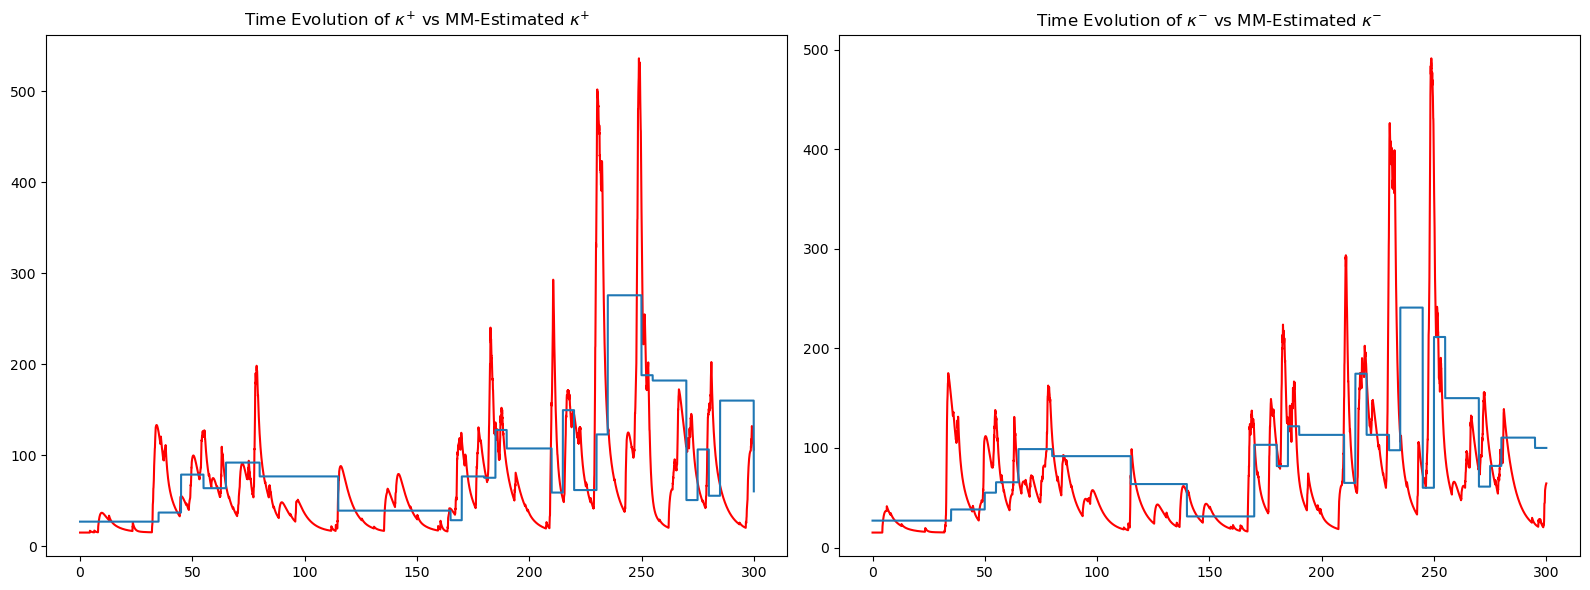

In [ ]:
line = 0

kappas1_pc = np.repeat(estimated_kappas1[line][:-1], update_rate)
kappas2_pc = np.repeat(estimated_kappas2[line][:-1], update_rate)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
axs[0].plot(np.linspace(0, T, N_total+1), kappa1_t[line], c='r')
axs[0].plot(np.linspace(0, T, N_total+1), np.concat((kappas1_pc, [estimated_kappas1[line][-1]])))
axs[0].set_title(r'Time Evolution of $\kappa^{+}$ vs MM-Estimated $\kappa^{+}$')
axs[1].plot(np.linspace(0, T, N_total+1), kappa2_t[line], c='r')
axs[1].plot(np.linspace(0, T, N_total+1), np.concat((kappas2_pc, [estimated_kappas2[line][-1]])))
axs[1].set_title(r'Time Evolution of $\kappa^{-}$ vs MM-Estimated $\kappa^{-}$')

plt.tight_layout()
plt.savefig('Kappa_Bump.png')
plt.savefig('Kappa_Bump.pdf', format='pdf')

In [ ]:
terminal_wealth = [MM_wealths[i][-1] + MM_positions[i][-1]*(S_t[i][-1]-l(MM_positions[i][-1])) for i in range(M)]
print(f'Mean: {np.mean(terminal_wealth)}, Std: {np.std(terminal_wealth, ddof=1)}')
print(f'Sharpe: {np.mean(terminal_wealth)/np.std(terminal_wealth, ddof=1)}')

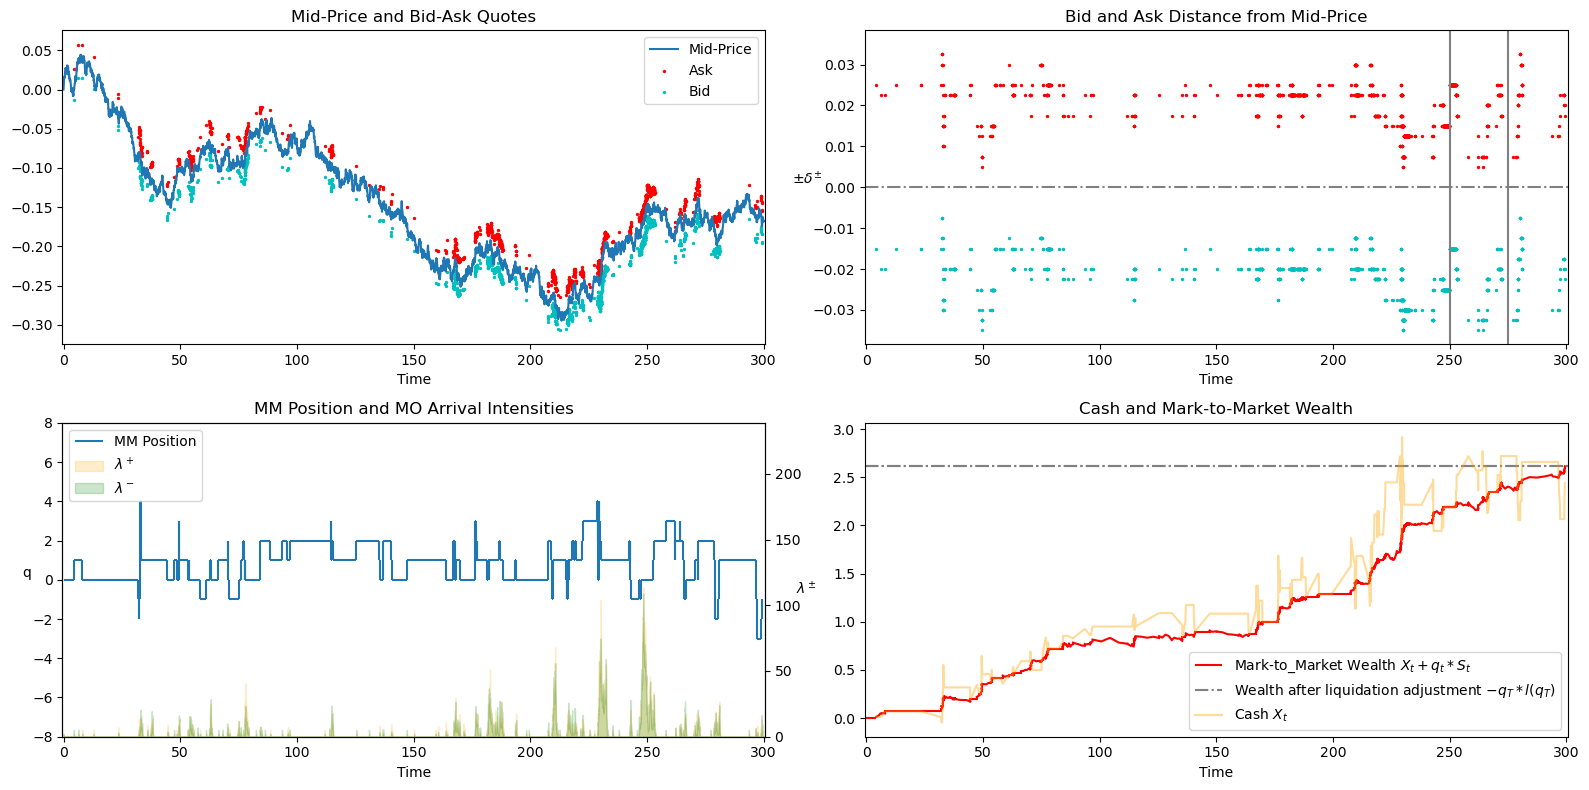

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
times = [MO_times_directions[line][i][0] for i in range(len(MO_times_directions[line]))]
axs[0][0].plot(np.linspace(0, T, N_total+1), S_t[line])
axs[0][0].scatter(times, [get_interpolated_stock(S_t[line], times[i]) + elem[0] for i, elem in enumerate(MM_deltas[line])], 
               c='r', s=2)
axs[0][0].scatter(times, [get_interpolated_stock(S_t[line], times[i]) - elem[1] for i, elem in enumerate(MM_deltas[line])],
               c='c', s=2)
axs[0][0].set_title('Mid-Price and Bid-Ask Quotes')
axs[0][0].legend(['Mid-Price', 'Ask', 'Bid'])

positions = MM_positions[line]
l1 = axs[1][0].hlines(0, xmin=N_est*T/N_total, xmax=times[0], label='MM Position')
axs[1][0].vlines(times[0], ymin=0, ymax=positions[0])
for i in range(len(times)-1):
    axs[1][0].hlines(positions[i], xmin=times[i], xmax=times[i+1])
    axs[1][0].vlines(times[i+1], ymin=positions[i], ymax=positions[i+1])
axs[1][0].set_ylim((-q_bar, q_bar))
axs[1][0].set_title('MM Position and MO Arrival Intensities')
for i in range(2):
    for j in range(2):
        axs[i][j].set_xlabel('Time')
        axs[i][j].set_xlim((-0.5, T+0.5))
axs[1][0].set_ylabel('q', rotation=0)
area_ax = axs[1][0].twinx()
area_ax.set_ylabel(r'$\lambda^\pm$', rotation=0)
l2 = area_ax.fill_between(np.linspace(N_est*T/N_total, T, N_total-N_est+1), lambd1_t[line][N_est:], color='orange', alpha=0.2, label=r'$\lambda^+$')
l3 = area_ax.fill_between(np.linspace(N_est*T/N_total, T, N_total-N_est+1), lambd2_t[line][N_est:], color='green', alpha=0.2, label=r'$\lambda^-$')
area_ax.set_ylim((0, area_ax.get_ylim()[1]*2))
axs[1][0].legend([l1, l2, l3], [l.get_label() for l in [l1, l2, l3]], loc=2)
        
axs[0][1].scatter(times, [elem[0] for elem in MM_deltas[line]], c='r', s=2)
axs[0][1].scatter(times, [-elem[1] for elem in MM_deltas[line]], c='c', s=2)
axs[0][1].set_ylabel(r'$\pm\delta^{\pm}$', rotation=0)
axs[0][1].set_title('Bid and Ask Distance from Mid-Price')
axs[0][1].axhline(y=0, linestyle='-.', c='grey')
axs[0][1].axvline(x=250, c='grey')
axs[0][1].axvline(x=275, c='grey')
y_max = np.abs(axs[0][1].get_ylim()).max()
axs[0][1].set_ylim((-y_max, y_max))
#axs[0][1].legend(['Ask', 'Bid', 'Mid'])

wealths = MM_wealths[line]
axs[1][1].hlines(y=0, xmin=N_est*T/N_total, xmax=times[0], color='r', label=r'Mark-to_Market Wealth $X_t + q_t*S_t$')
for i in range(len(times)-1):
    ts = np.linspace(times[i], times[i+1], 5)
    axs[1][1].plot(ts, [get_interpolated_stock(S_t[line], t)*positions[i]+wealths[i] for t in ts], c='r')
    stock = get_interpolated_stock(S_t[line], times[i+1])
    axs[1][1].vlines(x=times[i+1], ymin=stock*positions[i]+wealths[i], ymax=stock*positions[i+1]+wealths[i+1], color='r')
axs[1][1].axhline(stock*positions[i+1]+wealths[i+1], c='grey', linestyle='-.')
axs[1][1].axhline(stock*positions[i+1]+wealths[i+1] - positions[-1]*l(positions[-1]), c='grey', linestyle='-.', 
                  label=r'Wealth after liquidation adjustment $-q_T*l(q_T)$')
axs[1][1].plot(times, MM_wealths[line], c='orange', alpha=0.4, label=r'Cash $X_t$')
axs[1][1].set_title('Cash and Mark-to-Market Wealth')
axs[1][1].legend()

plt.tight_layout()
plt.savefig('KappaUpdate.png')
plt.savefig('KappaUpdate.pdf', format='pdf')

In [ ]:
'''
Function to generate the MM expected wealth, std and sharpe different combinations of uncertainty parameters.
'''

def bumped_get_expected_terminal_wealth(phi_alpha, phi_lambd, phi_kappa):
    S_t = np.zeros((M, N_total+1))
    alpha_t = np.zeros((M, N_total+1))
    lambd1_t, lambd2_t = np.zeros((M, N_total+1)), np.zeros((M, N_total+1))
    kappa1_t, kappa2_t = np.zeros((M, N_total+1)), np.zeros((M, N_total+1))
    dM_t1s, dM_t2s = np.zeros((M, N_total+1)), np.zeros((M, N_total+1))
    
    lambd1_t[:, 0], lambd2_t[:, 0] = 2, 2
    kappa1_t[:, 0], kappa2_t[:, 0] = 15, 15

    # 53 values
    kappa_range = np.concat((np.arange(15, 31, 1), np.arange(40, 405, 10)))
    precomputed_deltas = {}
    for i, kappa1 in enumerate(kappa_range):
        for j, kappa2 in enumerate(kappa_range):
            delta_pos, delta_neg = get_delta_parallel(phi_alpha, phi_lambd, phi_kappa, T, N_numerical)
            precomputed_deltas[(i, j)] = np.array((delta_pos, delta_neg))
    
    start = time.time()
    MM_positions, MM_deltas, MM_wealths = [], [], []
    terminal_wealths = []
    
    for j in range(M):
        kappa1, kappa2 = 27, 27
        distances_over, distances_under = [], []
        MM_position, MM_delta, MM_wealth = [], [], []
        current_position = 0
        current_wealth = 0
        total_MM_orders_1, total_MM_orders_2 = 0, 0
        current_period_trades1, current_period_trades2 = 0, 0
    
        z = normal(0, 1, N_total)
        delta_pos, delta_neg = estimate_delta()
        
        for i in range(1, N_total+1):
            if i%update_rate == 0:
                if len(distances_over) > 10:
                    kappa1 = 1/np.mean(distances_over)
                if len(distances_under) > 10:
                    kappa2 = 1/np.mean(distances_under)

                if len(distances_under) > 10 or len(distances_over) > 10:
                    delta_pos, delta_neg = estimate_delta()
                    
                if len(distances_over) > 10:
                    distances_over = []
                if len(distances_under) > 10:
                    distances_under = []

            dM_t1, dM_t2 = poisson(lambd1_t[j, i-1]*dt), poisson(lambd2_t[j, i-1]*dt)
            dM_t1s[j, i], dM_t2s[j, i] = dM_t1, dM_t2
            kappa1_t[j, i] = kappa1_t[j, i-1] + b_k*(theta_k + total_MM_orders_1 - kappa1_t[j, i-1])*dt + eta_k * dM_t1 + nu_k * dM_t2
            kappa2_t[j, i] = kappa2_t[j, i-1] + b_k*(theta_k + total_MM_orders_2 - kappa2_t[j, i-1])*dt + eta_k * dM_t2 + nu_k * dM_t1
            lambd1_t[j, i] = lambd1_t[j, i-1] + b_lambd*(theta_lambd - lambd1_t[j, i-1])*dt + eta_lambd * dM_t1 + nu_lambd * dM_t2
            lambd2_t[j, i] = lambd2_t[j, i-1] + b_lambd*(theta_lambd - lambd2_t[j, i-1])*dt + eta_lambd * dM_t2 + nu_lambd * dM_t1
            alpha_t[j, i] = alpha_t[j, i-1] - b_alpha*alpha_t[j, i-1]*dt + eps1 * dM_t1 - eps2 * dM_t2
            S_t[j, i] = S_t[j, i-1] + alpha_t[j, i-1]*dt + sigma*np.sqrt(dt)*z[i-1]
            current_period_trades1, current_period_trades2 = 0, 0
            if dM_t1 >= 1 or dM_t2 >= 1:
                total_trades = dM_t1+dM_t2
                directions = np.array([1]*dM_t1 + [-1]*dM_t2)
                uniform_times = (i-1)*dt + np.random.uniform(size=total_trades)*dt
                directions = directions[uniform_times.argsort()]
                uniform_times.sort()
                for k in range(total_trades):
                    if current_position == -q_bar:
                        d = get_interpolated_delta_tick(delta_neg[0], uniform_times[k])
                        deltas = (np.inf, d)
                    elif current_position == q_bar:
                        d = get_interpolated_delta_tick(delta_pos[-1], uniform_times[k])
                        deltas = (d, np.inf)
                    else:
                        d1 = get_interpolated_delta_tick(delta_pos[current_position+q_bar-1], uniform_times[k])
                        d2 = get_interpolated_delta_tick(delta_neg[current_position+q_bar], uniform_times[k])
                        deltas = (d1, d2)
                    
                    stock_price = get_interpolated_stock(S_t[j], uniform_times[k])
                    u = np.random.uniform()
                    if directions[k] == 1:
                        kappa_aux = get_interpolated_kappa(kappa1_t[j], uniform_times[k])
                        distance_over = -(1/kappa_aux)*np.log(u)
                        
                        if distance_over>deltas[0]:
                            current_position -= 1
                            current_period_trades1 += 1
                            current_wealth += stock_price + deltas[0]
    
                        distance_over = np.ceil((distance_over+zero_distance_epsilon) / tick_size) * tick_size
                        distances_over.append(distance_over)
                            
                    else:
                        kappa_aux = get_interpolated_kappa(kappa2_t[j], uniform_times[k])
                        distance_under =-(1/kappa_aux)*np.log(u)
                        
                        if distance_under>deltas[1]:
                            current_position += 1
                            current_period_trades2 += 1
                            current_wealth -= stock_price - deltas[1]
                        distance_under = np.ceil((distance_under+zero_distance_epsilon) / tick_size) * tick_size
                        distances_under.append(distance_under)
                    MM_position.append(current_position)
                    MM_delta.append(deltas)
                    MM_wealth.append(current_wealth)
            total_MM_orders_1 = 30*current_period_trades1 + 0.99*total_MM_orders_1
            total_MM_orders_2 = 30*current_period_trades2+ 0.99*total_MM_orders_2
        MM_positions.append(MM_position)
        MM_deltas.append(MM_delta)
        MM_wealths.append(MM_wealth)


        if len(MM_position) == 0:
            final_position = 0
        else:
            final_position = MM_position[-1]
            
        terminal_wealth = S_t[j][-1]*final_position+MM_wealth[-1] - final_position*l(final_position)
        terminal_wealths.append(terminal_wealth)
    print('Phis: ', phi_alpha, phi_lambd, phi_kappa)
    print('Mean: ', np.round(np.mean(terminal_wealths), 4), 'std: ', np.round(np.std(terminal_wealths), 4))
    print(time.time()-start, 'seconds.')
    print('-'*20)
    return np.mean(terminal_wealths), np.std(terminal_wealths, ddof=1), MM_positions, MM_deltas, MM_wealths
        

In [ ]:
M = 10000
phi_alphas = 0
phi_lambd = 0
phi_kappas = [2, 5, 10, 20, 50, 150, 300, 500]
bumped_expected_terminal_wealths = np.zeros(len(phi_kappas))
bumped_expected_terminal_wealth_stds = np.zeros(len(phi_kappas))

np.random.seed(0)

for i, phi_kappa in enumerate(phi_kappas):
    expected_terminal_wealth, expected_terminal_wealth_std, MM_positions, MM_deltas, MM_wealths = bumped_get_expected_terminal_wealth(phi_alpha, phi_lambd, phi_kappa)
    bumped_expected_terminal_wealths[i] = expected_terminal_wealth
    bumped_expected_terminal_wealth_stds[i] = expected_terminal_wealth_std

In [ ]:
print(bumped_expected_terminal_wealths)
print(bumped_expected_terminal_wealth_stds)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

for i in range(len(expected_terminal_wealths)):
    axs[0].plot(bumped_expected_terminal_wealth_stds[i], bumped_expected_terminal_wealths[i], label=rf'$\phi_\alpha = {int(phi_alphas[i])}$')
    axs[0].scatter(bumped_expected_terminal_wealth_stds[i], bumped_expected_terminal_wealths[i], s=8)
    axs[1].plot(phis, bumped_expected_terminal_wealths[i]/bumped_expected_terminal_wealth_stds[i], label=rf'$\phi_\alpha = {int(phi_alphas[i])}$')
    axs[1].scatter(phis, bumped_expected_terminal_wealths[i]/bumped_expected_terminal_wealth_stds[i], s=8)
axs[0].set_xlim((axs[0].get_xlim()[0]-0.02, axs[0].get_xlim()[1]+0.02))
axs[0].annotate(rf'$\phi={phis[0]}$', xy=(bumped_expected_terminal_wealth_stds[0][0]+0.005, bumped_expected_terminal_wealths[0][0]))
#axs[0].annotate(rf'$\phi={phis[0]}$', xy=(expected_terminal_wealth_stds[1][0]+0.005, expected_terminal_wealths[1][0]))
axs[0].annotate(rf'$\phi={phis[-1]}$', xy=(bumped_expected_terminal_wealth_stds[0][-1], bumped_expected_terminal_wealths[0][-1]-0.02))
#axs[0].annotate(rf'$\phi={phis[-1]}$', xy=(expected_terminal_wealth_stds[1][-1]+0.002, expected_terminal_wealths[1][-1]))

axs[0].set_xlabel('Standard Deviation of Profit')
axs[0].set_ylabel('Expected Profit')
axs[0].legend()
axs[1].set_xlabel(r'$\phi = \phi_\lambda = \phi_\kappa$')
axs[1].set_ylabel(r'Expectation / Std of Profit')
#axs[1].legend();

plt.savefig('BumpedSharpe.png')
plt.savefig('BumpedSharpe.pdf', format='pdf')

## Convex l(q) defined

Same experiments but using a convex l(q) function.

In [ ]:
def get_expected_terminal_wealth(phi_alpha, phi_lambd, phi_kappa):

    start = time.time()
    
    MM_positions = []
    MM_deltas = []
    MM_wealths = []
    terminal_wealths = []
    
    alpha, sigma = 0, 0.01
    delta_pos, delta_neg = get_delta_parallel(phi_alpha, phi_lambd, phi_kappa, T, N_numerical)
    
    for i in range(M):
        
        current_position = 0
        current_wealth = 0
        MM_position = []
        MM_delta = []
        MM_wealth = []
        unif = np.random.uniform(size=(len(MO_times_directions[i])))
        for j, (t, direction, _) in enumerate(MO_times_directions[i]):
            if current_position == -q_bar:
                deltas = (np.inf, get_interpolated_delta(delta_neg[0], t))
            elif current_position == q_bar:
                deltas = (get_interpolated_delta(delta_pos[-1], t), np.inf)
            else:
                deltas = (get_interpolated_delta(delta_pos[current_position+q_bar-1], t), get_interpolated_delta(delta_neg[current_position+q_bar], t))
            stock_price = get_interpolated_stock(S_t[i], t)
            
            if direction == 1:
                if unif[j] < np.exp(-get_interpolated_kappa(kappa1_t[i], t)*deltas[0]):
                    current_position -= 1
                    current_wealth += stock_price + deltas[0]
                    MO_times_directions[i][j][2] = 1
            else:
                if unif[j] < np.exp(-get_interpolated_kappa(kappa2_t[i], t)*deltas[1]):
                    current_position += 1
                    current_wealth -= stock_price - deltas[1]
                    MO_times_directions[i][j][2] = -1
                    
            MM_position.append(current_position)
            MM_delta.append(deltas)
            MM_wealth.append(current_wealth)
        MM_positions.append(MM_position)
        MM_deltas.append(MM_delta)
        MM_wealths.append(MM_wealth)

        if len(MM_position) == 0:
            final_position = 0
        else:
            final_position = MM_position[-1]
            
        terminal_wealth = S_t[i][-1]*final_position+MM_wealths[i][-1] - final_position*l(final_position)
        terminal_wealths.append(terminal_wealth)
    print('Phis: ', phi_alpha, phi_lambd, phi_kappa)
    print('Mean: ', np.round(np.mean(terminal_wealths), 4), 'std: ', np.round(np.std(terminal_wealths), 4))
    print(time.time()-start, 'seconds.')
    print('-'*20)
    return np.mean(terminal_wealths), np.std(terminal_wealths, ddof=1), MM_positions, MM_deltas, MM_wealths

N_numerical = 6000
numerical_dt = (1-N_est/N_total)*T/N_numerical

lambd1, lambd2 = 2, 2
kappa1, kappa2 = 27, 27

phi_alphas = [0,2,4, 6,8,10]
phis = [0,3,6,9, 12, 15, 18, 21, 24, 27, 30]
expected_terminal_wealths = np.zeros((len(phi_alphas), len(phis)))
expected_terminal_wealth_stds = np.zeros((len(phi_alphas), len(phis)))

for i, phi_alpha in enumerate(phi_alphas):
    for j, phi in enumerate(phis):
        expected_terminal_wealth, expected_terminal_wealth_std, MM_positions, MM_deltas, MM_wealths = get_expected_terminal_wealth(phi_alpha, phi, phi)
        expected_terminal_wealths[i][j] = expected_terminal_wealth
        expected_terminal_wealth_stds[i][j] = expected_terminal_wealth_std

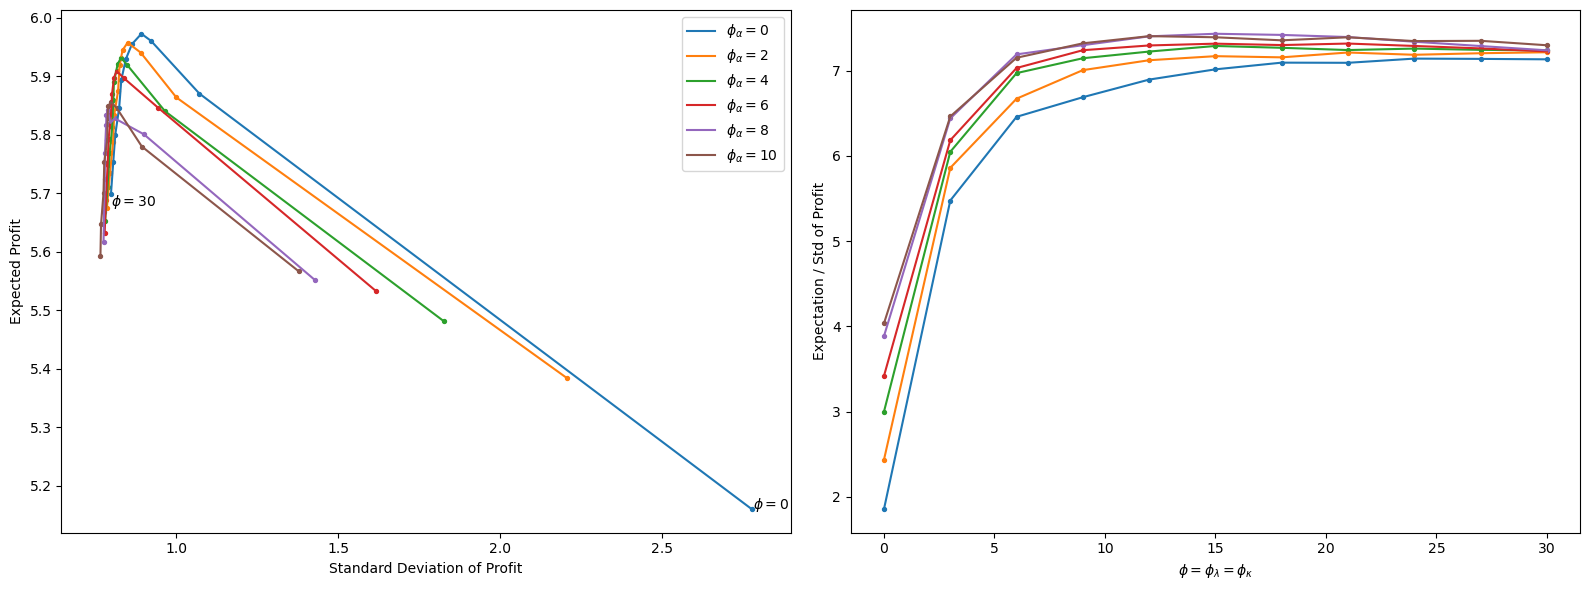

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

for i in range(len(expected_terminal_wealths)):
    axs[0].plot(expected_terminal_wealth_stds[i], expected_terminal_wealths[i], label=rf'$\phi_\alpha = {int(phi_alphas[i])}$')
    axs[0].scatter(expected_terminal_wealth_stds[i], expected_terminal_wealths[i], s=8)
    axs[1].plot(phis, expected_terminal_wealths[i]/expected_terminal_wealth_stds[i], label=rf'$\phi_\alpha = {int(phi_alphas[i])}$')
    axs[1].scatter(phis, expected_terminal_wealths[i]/expected_terminal_wealth_stds[i], s=8)
axs[0].set_xlim((axs[0].get_xlim()[0]-0.02, axs[0].get_xlim()[1]+0.02))
axs[0].annotate(rf'$\phi={phis[0]}$', xy=(expected_terminal_wealth_stds[0][0]+0.005, expected_terminal_wealths[0][0]))
#axs[0].annotate(rf'$\phi={phis[0]}$', xy=(expected_terminal_wealth_stds[1][0]+0.005, expected_terminal_wealths[1][0]))
axs[0].annotate(rf'$\phi={phis[-1]}$', xy=(expected_terminal_wealth_stds[0][-1], expected_terminal_wealths[0][-1]-0.02))
#axs[0].annotate(rf'$\phi={phis[-1]}$', xy=(expected_terminal_wealth_stds[1][-1]+0.002, expected_terminal_wealths[1][-1]))

axs[0].set_xlabel('Standard Deviation of Profit')
axs[0].set_ylabel('Expected Profit')
axs[0].legend()
axs[1].set_xlabel(r'$\phi = \phi_\lambda = \phi_\kappa$')
axs[1].set_ylabel(r'Expectation / Std of Profit')
#axs[1].legend();
plt.tight_layout()
plt.savefig('Sharpe_convex.png')
plt.savefig('Sharpe_convex.pdf', format='pdf')

## Tradeoff $\phi_\kappa$ number of trades vs Sharpe

Generation of figure for the tradeoff when increasing $\phi_\kappa$ between the EV of the MM, the std and the sharpe ratio (compared to the ammount of extra trades that he gets when being uncertsain (tights the spread))

In [ ]:
M = 15000
phi_kappas = [2, 5, 10, 20, 50, 150, 300, 500]
phis = [0]
bumped_expected_terminal_wealths = np.zeros((len(phi_kappas), len(phis)))
bumped_expected_terminal_wealth_stds = np.zeros((len(phi_kappas), len(phis)))
bumped_deltas = np.zeros((len(phi_kappas), len(phis)))
T = 300
N_total = 6000
N_est = 0

update_rate = 50
tick_size = 0.0025
zero_distance_epsilon = 10**-7

q_bar = 8
qs = np.arange(-q_bar, q_bar+1)
theta = 0.001

dt = T/N_total


sigma = 0.01
eps1, eps2 = 0.001, 0.001
b_alpha = 1
theta_lambd = 0.2
b_lambd = 70/9
eta_lambd = 5

nu_lambd = 2
theta_k = 15
b_k = 7/6
eta_k = 5
nu_k = 2
number_of_trades = []

N_numerical = 6000
numerical_dt = (1-N_est/N_total)*T/N_numerical
lambd1, lambd2 = 2, 2
kappa1, kappa2 = 27, 27

phi_alpha = 10
phi_lambd, phi_kappa = 6, 6
estimated_kappas1, estimated_kappas2 = [], []
alpha, sigma = 0, 0.01

MO_times_directions = []
MM_positions, MM_deltas, MM_wealths = [], [], []


np.random.seed(0)

for i, phi_kappa in enumerate(phi_kappas):
    for j, phi in enumerate(phis):

        kappa_range = np.concatenate((np.arange(15, 31, 1), np.arange(40, 405, 10)))
        precomputed_deltas = {}
        for ii, kappa in enumerate(kappa_range):
            for jj, kappa in enumerate(kappa_range):
                kappa1, kappa2 = kappa, kappa
                delta_pos, delta_neg = get_delta_parallel(phi, phi, phi_kappa, T, N_numerical)
                precomputed_deltas[(ii, jj)] = np.array((delta_pos, delta_neg))
        expected_terminal_wealth, expected_terminal_wealth_std, MM_positions, MM_deltas, MM_wealths = bumped_get_expected_terminal_wealth(phi, phi, phi_kappa)
        bumped_expected_terminal_wealths[i][j] = expected_terminal_wealth
        bumped_expected_terminal_wealth_stds[i][j] = expected_terminal_wealth_std
        s=0
        for line in range(M):
            s+=np.sum(np.abs(np.array(MM_positions[line][1:]) - np.array(MM_positions[line][:-1])))
        number_of_trades.append(s/M)

In [ ]:
sharpes = [bumped_expected_terminal_wealths[0][i]/bumped_expected_terminal_wealth_stds[0][i] for i in range(len(phi_kappas))]

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))


ax[0].plot(phi_kappas, bumped_expected_terminal_wealths[0], marker='o', linestyle='-', label='Expected Value')
ax[0].plot(phi_kappas, bumped_expected_terminal_wealth_stds[0], marker='o', linestyle='-', label='std')
ax[0].plot(phi_kappas, sharpes, marker='o', linestyle='--', label='Sharpe')
ax[0].set_xscale('log')
ax[0].set_xlabel(r'$\phi_\kappa$')
ax[0].set_title('Expected Value, std, and Sharpe Ratio of Wealth')
ax[0].legend()
ax[1].plot(phi_kappas, t, marker='o', linestyle='-', label='w')
ax[1].set_xscale('log')
ax[1].set_xlabel(r'$\phi_\kappa$')
ax[1].set_title('Number of Executed Trades')
plt.tight_layout()
plt.savefig("phi_kappa_last_log.pdf", bbox_inches='tight')
plt.show()